In [1]:
library(reticulate)
# use_python("/opt/conda/envs/GSI/bin/python3.10",required=T)
# py_config()
library(rhdf5)
library(Seurat)
library(ggplot2)
library(dplyr)
library(readr)
library(spatialLIBD)
library(aricode)
library(glue)
library(patchwork)
library(arrow)
library(harmony)
source('/workspace/volume/spatial_integration/BEER/BEER.R')

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SpatialExperiment

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package

[1] "Welcome to BEER (v0.1.9)!"


Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:IRanges’:

    collapse


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.

Loading required package: genefilter


Attaching package: ‘genefilter’


The following object is masked from ‘package:patchwork’:

    area


The following objects are masked from ‘package:MatrixGenerics’:

    rowSds, rowVars


The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars


The following object is masked from ‘package:readr’:

    spec


Loading required package: BiocParallel


Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA




In [2]:
sessionInfo()

R version 4.3.0 (2023-04-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

time zone: Asia/Seoul
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] limma_3.56.2                sva_3.48.0                 
 [3] BiocParallel_1.34.2         genefilter_1.82.1          
 [5] mgcv_1.9-0                  nlme_3.1-162               
 [7] harmony_1.2.1               Rcpp_1.0.12                
 [9] arrow_16.1.0                patchwork_1.1.3.9

In [3]:
getwd()

[1] "/workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow"

In [ ]:
dataset = 'DLPFC' #dataset to process ['DLPFC', 'Coronal']

<h4>DLPFC sample folder setting</h4>

In [4]:
if (dataset == 'DLPFC'){ 
    sample_names <- c('151507', '151672', '151673')
    # dataset_folder = '/workspace/volume/spatial_integration/GNN_based/combined'
    dataset_folder = '/workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/dataset'
    save_data_name = 'embed_all_dlpfc'
    feather_folder = 'dataset/embed_all_com3all.feather' #Step 4 output file folder
    spe_all <- readRDS(file.path(dataset_folder,'/spe_all.rds')) #spe.rds file read
}

In [5]:
file.path(dataset_folder,'spe_all.rds') #spe rds File to dataset folder

[1] "/workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/dataset/spe_all.rds"

<h4>Mouse Coronal folder setting</h4>

In [2]:
if (dataset == 'Coronal'){
    sample_names <- c('coronal_section1', 'coronal_section2')
    # dataset_folder = '/workspace/volume/spatial_integration/GNN_based/combined'
    dataset_folder = '/workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/dataset'
    save_data_name = 'embed_all_coronal'
    feather_folder = 'dataset/embed_all_coronal.feather' #Step 4 output file folder
}

<h1>Data Loading</h1>

In [7]:
start_time <- Sys.time()

# spe_all <- readRDS(file.path(dataset_folder,'/spe_all.rds'))
spe_list <- list()
data_list <- list()
BATCH <- c()
LAYER <- c()
i = 1

for (sample_name in sample_names){
    data_active <- data_list[[sample_name]]

    if (dataset == 'DLPFC'){
        data_active <- readRDS(file.path(dataset_folder,paste0('samples/df_logcounts_', sample_name,'.rds')))
        spe_list[[sample_name]] <- spe_all[, spe_all$sample_id == sample_name]
        LAYER <- c(LAYER, as.character(spe_list[[sample_name]]$'layer_guess'))
        data_list[[sample_name]] <- data_active
        }
    if (dataset == 'Coronal'){
        data_active <- read_feather(file.path(dataset_folder,paste0('samples/df_logcounts_', sample_name,'.feather')))
        data_active = as.data.frame(data_active)
        rownames(data_active) = data_active[,ncol(data_active)]
        data_active[, ncol(data_active)] <- NULL
        data_list[[sample_name]] <- data_active
        }
    # 
    
    batch_name <- paste0('Batch ', i)
    BATCH <- c(BATCH, rep(batch_name, ncol(data_list[[sample_name]])))
    # 
    i = i + 1
}

DATA_default <- do.call(cbind, data_list)
colnames(DATA_default) <- gsub("^[^.]*\\.", "", colnames(DATA_default))
if (dataset == 'DLPFC'){
    char_layer <- as.character(LAYER)
    }

DATA2 <- read_feather(file.path(feather_folder))
DATA2 = as.data.frame(DATA2)
rownames(DATA2) = DATA2[,ncol(DATA2)]
DATA2[, ncol(DATA2)] <- NULL

end_time <- Sys.time()
duration <- end_time - start_time
print(duration)

Time difference of 16.76359 secs


In [8]:
# check for duplicate rownames
data_rownames <- rownames(DATA_default)
data_rownames_duplicated <- duplicated(data_rownames)
data_rownames[data_rownames_duplicated]

character(0)

In [9]:
dim(DATA_default)
dim(DATA2)

[1] 33538 11880

[1] 67076 11880

<h2>Integrated w/ spatial w/ BEER Batch Effect Removal</h2>

In [10]:
data_rownames <- rownames(DATA2)
data_rownames_duplicated <- duplicated(data_rownames)
data_rownames[data_rownames_duplicated]

character(0)

In [11]:
mybeer=BEER(DATA2, BATCH, GNUM=50, PCNUM=30, ROUND=2, GN=1000, SEED=1, COMBAT=TRUE)

[1] "BEER start!"
[1] "2024-12-24 14:36:58 KST"


Loading required package: stringi



[1] "Group number (GNUM) is:"
[1] 50
[1] "Varible gene number (GN) of each batch is:"
[1] 1000
[1] "ROUND is:"
[1] 2
[1] 1
[1] "Batch 1"
[1] 2
[1] "Batch 2"
[1] 3
[1] "Batch 3"
[1] "Total varible gene number (GN) is:"
[1] 1952
Found 119 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found3batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Centering and scaling data matrix



[1] "Calculating PCs ..."


PC_ 1 
Positive:  ENSG00000168314 
Negative:  ENSG00000112186 

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:41:15 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

14:41:15 Read 11880 rows and found 30 numeric columns

14:41:15 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

14:41:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

[1] "Get group for:"
[1] "Batch 1"
[1] "Group Number:"
[1] 50
[1] "Get group for:"
[1] "Batch 2"
[1] "Group Number:"
[1] 50
[1] "Get group for:"
[1] "Batch 3"
[1] "Group Number:"
[1] 50
[1] "Finding MN pairs..."
[1] "1 / 150"
[1] "101 / 150"
[1] "ROUND:"
[1] 1
[1] "ROUND:"
[1] 2
[1] "Number of MN pairs:"
[1] 26
[1] "Evaluating PCs ..."
[1] "Start"


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 1


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 2


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 3


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 4


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 5


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 6


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 7


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 8


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 9


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 10


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 11


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 12


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 13


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 14


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 15


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 16


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 17


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 18


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 19


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 20


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 21


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 22


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 23


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 24


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 25


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 26


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 27


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 28


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 29


Warning message in cor.test.default(lst1_quantile, lst2_quantile, method = CORMETHOD):
“Cannot compute exact p-value with ties”


[1] 30
[1] "Finished!!!"
[1] "############################################################################"
[1] "BEER cheers !!! All main steps finished."
[1] "############################################################################"
[1] "2024-12-24 14:42:53 KST"


In [12]:
mybeer$seurat

An object of class Seurat 
67076 features across 11880 samples within 1 assay 
Active assay: RNA (67076 features, 1952 variable features)
 2 dimensional reductions calculated: pca, umap

In [13]:
pbmc <- mybeer$seurat
PCUSE <- mybeer$select
pbmc@meta.data$orig.ident=LAYER
pbmc <- RunUMAP(object = pbmc, reduction='pca',dims = PCUSE, umap.method='umap-learn', metric='correlation')

<h5>Finetune resolution parameter until number of communities = 7</h5>

In [14]:
pbmc <- FindNeighbors(object = pbmc, reduction='pca')
pbmc <- FindClusters(object = pbmc)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11880
Number of edges: 338230

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7557
Number of communities: 11
Elapsed time: 1 seconds


In [15]:
# pbmc <- FindNeighbors(object = pbmc)
pbmc <- FindClusters(object = pbmc, resolution = 0.5) #higher resolution gets higher number communities 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11880
Number of edges: 338230

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8024
Number of communities: 7
Elapsed time: 2 seconds


In [16]:
silhouette_seurat <- function(sobject,
                              cluster_col = "seurat_clusters",
                              dims = c(1:10)) {
    sil_obj <- cluster::silhouette(
        x = sobject@meta.data[[cluster_col]] %>%
            as.character() %>%
            as.numeric(),
        dist = Seurat::Embeddings(sobject,
                                  reduction = "pca")[, dims] %>%
        stats::dist())

    return(sil_obj)
}

In [17]:
listings = pbmc@meta.data[['batch']]
numbered_list <- as.integer(factor(listings, levels = unique(listings)))
batch_numeric <- numbered_list
names(batch_numeric) <- colnames(x=pbmc)
pbmc<- AddMetaData(
    object = pbmc,
    metadata = batch_numeric,
    col.name = 'batch_numeric'
    )
# head(x=pbmc)

In [18]:
listings = pbmc@meta.data[['orig.ident']]
numbered_list <- as.integer(factor(listings, levels = unique(listings)))
ident_numeric <- numbered_list
names(ident_numeric) <- colnames(x=pbmc)
pbmc<- AddMetaData(
    object = pbmc,
    metadata = ident_numeric,
    col.name = 'ident_numeric'
    )
# head(x=pbmc)

In [20]:
pbmc_nona_var <- pbmc[,!is.na(pbmc$orig.ident)] #filters out n/a labels

In [21]:
na_filled <- list()
for (batch in unique(pbmc_nona_var$batch)){
    na_filled[[batch]] <- pbmc_nona_var[, pbmc_nona_var$batch==batch]
}
names(na_filled)

[1] "Batch 1" "Batch 2" "Batch 3"

<h3>save processed data to h5ad</h3>

In [24]:
library(Seurat)
library(SeuratData)
library(SeuratDisk)
file_name = paste0(dataset_folder, '/samples/beer_', save_data_name,'.h5Seurat')
SaveH5Seurat(pbmc, filename = file_name)
Convert(file_name, dest = "h5ad")
print(paste0('saved to ',file_name))

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

Adding variable features for RNA

No feature-level metadata found for RNA

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding scale.data from RNA as X

Adding data from RNA as raw

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

Adding RNA_snn as neighbors



[1] "saved to /workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/dataset/samples/beer_embed_all_com3all_unfil.h5Seurat"


<h1>Integrated w/o spatial info w/ BEER</h1>

In [14]:
mybeer2=BEER(DATA_default, BATCH, GNUM=50, PCNUM=30, ROUND=2, GN=1000, SEED=1, COMBAT=TRUE)

[1] "BEER start!"
[1] "2025-05-07 16:04:14 KST"
[1] "Group number (GNUM) is:"
[1] 50
[1] "Varible gene number (GN) of each batch is:"
[1] 1000
[1] "ROUND is:"
[1] 2
[1] 1
[1] "Batch 1"
[1] 2
[1] "Batch 2"
[1] "Total varible gene number (GN) is:"
[1] 1287


Warning message:
“Non-unique cell names (colnames) present in the input matrix, making unique”


Found 8 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Centering and scaling data matrix



[1] "Calculating PCs ..."


PC_ 1 
Positive:  Ecrg4 
Negative:  Chn1 

16:04:34 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

16:04:34 Read 4545 rows and found 30 numeric columns

16:04:34 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

16:04:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:04:35 Writing NN index file to temp file /tmp/RtmpF1r6Nk/filec0c7e4d1ca3f4

16:04:35 Searching Annoy index using 1 thread, search_k = 3000

16:04:37 Annoy recall = 100%

16:04:38 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:04:4

[1] "Get group for:"
[1] "Batch 1"
[1] "Group Number:"
[1] 50
[1] "Get group for:"
[1] "Batch 2"
[1] "Group Number:"
[1] 50
[1] "Finding MN pairs..."
[1] "1 / 100"
[1] "ROUND:"
[1] 1
[1] "ROUND:"
[1] 2
[1] "Number of MN pairs:"
[1] 36
[1] "Evaluating PCs ..."
[1] "Start"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] "Finished!!!"
[1] "############################################################################"
[1] "BEER cheers !!! All main steps finished."
[1] "############################################################################"
[1] "2025-05-07 16:05:01 KST"


In [15]:
mybeer2$seurat

An object of class Seurat 
19465 features across 4545 samples within 1 assay 
Active assay: RNA (19465 features, 1287 variable features)
 2 dimensional reductions calculated: pca, umap

In [16]:
pbmc2 <- mybeer2$seurat
PCUSE <- mybeer2$select
# pbmc2@meta.data$orig.ident=LAYER
pbmc2 <- RunUMAP(object = pbmc2, reduction='pca',dims = PCUSE, umap.method='umap-learn', metric='correlation')

<h5>Finetune resolution parameter</h5>

In [ ]:
pbmc2 <- FindNeighbors(object = pbmc2, reduction='pca')
pbmc2 <- FindClusters(object = pbmc2)

In [ ]:
# pbmc <- FindNeighbors(object = pbmc)
pbmc2 <- FindClusters(object = pbmc2, resolution = 0.2) #higher resolution gets higher number communities 

In [27]:
listings = pbmc2@meta.data[['batch']]
numbered_list <- as.integer(factor(listings, levels = unique(listings)))
batch_numeric <- numbered_list
names(batch_numeric) <- colnames(x=pbmc2)
pbmc2<- AddMetaData(
    object = pbmc2,
    metadata = batch_numeric,
    col.name = 'batch_numeric'
    )
# head(x=pbmc)

In [29]:
listings = pbmc2@meta.data[['orig.ident']]
numbered_list <- as.integer(factor(listings, levels = unique(listings)))
ident_numeric <- numbered_list
names(ident_numeric) <- colnames(x=pbmc2)
pbmc2<- AddMetaData(
    object = pbmc2,
    metadata = ident_numeric,
    col.name = 'ident_numeric'
    )
# head(x=pbmc)

In [28]:
pbmc2_nona_var <- pbmc2[,!is.na(pbmc$orig.ident)] #filters out n/a labels

In [29]:
na_filled2 <- list()
for (batch in unique(pbmc2_nona_var$batch)){
    na_filled2[[batch]] <- pbmc2_nona_var[, pbmc2_nona_var$batch==batch]
}
names(na_filled2)

[1] "Batch 1" "Batch 2"

<h3>save processed data to h5ad</h3>

In [47]:
file_name = paste0(dataset_folder, '/samples/beer_default_', save_data_name,'.h5Seurat')
SaveH5Seurat(pbmc2, filename = file_name)
Convert(file_name, dest = "h5ad")
print(paste0('saved to ',file_name))

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

Adding variable features for RNA

No feature-level metadata found for RNA

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding scale.data from RNA as X

Adding data from RNA as raw

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

Adding RNA_snn as neighbors



[1] "saved to /workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/dataset/samples/beer_default_embed_all_coronal.h5Seurat"


<h2>Integrated w/o spatial info w/o BEER Removal (Added HARMONY)</h2>

In [28]:
pbmc_batch=CreateSeuratObject(counts = DATA_default, min.cells = 0, min.features = 0, project = "ALL") 
pbmc_batch@meta.data$batch=BATCH
pbmc_batch@meta.data$orig.ident=char_layer
pbmc_batch=FindVariableFeatures(object = pbmc_batch, selection.method = "vst", nfeatures = 2000)   
# VariableFeatures(object = pbmc_batch)
pbmc_batch <- NormalizeData(object = pbmc_batch, normalization.method = "LogNormalize", scale.factor = 10000)
pbmc_batch <- ScaleData(object = pbmc_batch, features = VariableFeatures(object = pbmc_batch))
pbmc_batch <- RunPCA(object = pbmc_batch, seed.use=123, npcs=50, features = VariableFeatures(object = pbmc_batch), ndims.print=1,nfeatures.print=1)
pbmc_batch <- RunUMAP(pbmc_batch, dims = 1:50, seed.use = 123,n.components=2, umap.method = "umap-learn",  metric="correlation")
# DimPlot(pbmc_batch, reduction='umap', group.by='batch', pt.size=0.1) 

pbmc_batch_default <- pbmc_batch

Warning message:
“Non-unique cell names (colnames) present in the input matrix, making unique”
Centering and scaling data matrix

PC_ 1 
Positive:  ENSG00000187094 
Negative:  ENSG00000168314 



In [29]:
pbmc_batch <- RunHarmony(pbmc_batch, 'batch')

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


<h5>Finetune resolution parameter until number of communities = 7</h5>

In [30]:
pbmc_batch <- FindNeighbors(object = pbmc_batch, reduction='harmony')

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11880
Number of edges: 343928

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8069
Number of communities: 7
Elapsed time: 2 seconds


In [32]:
pbmc_batch <- FindClusters(object = pbmc_batch, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11880
Number of edges: 343928

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8069
Number of communities: 7
Elapsed time: 2 seconds


In [31]:
pbmc_batch_default <- FindNeighbors(object = pbmc_batch_default, reduction='pca')

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11880
Number of edges: 340365

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8180
Number of communities: 7
Elapsed time: 2 seconds


In [33]:
pbmc_batch_default <- FindClusters(object = pbmc_batch_default, resolution = 0.4)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11880
Number of edges: 340365

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8180
Number of communities: 7
Elapsed time: 1 seconds


<h3>save processed data to h5ad</h3>

In [48]:
file_name = paste0(dataset_folder, '/samples/Harmony_default_', save_data_name,'.h5Seurat')
SaveH5Seurat(pbmc_batch, filename = file_name)
Convert(file_name, dest = "h5ad")
print(paste0('saved to ',file_name))

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

Adding variable features for RNA

Adding feature-level metadata for RNA

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Adding cell embeddings for harmony

Adding loadings for harmony

Adding projected loadings for harmony

Adding standard deviations for harmony

No JackStraw data for harmony

Validating h5Seurat file

Adding scale.data from RNA as X

Transfering meta.features to var

Adding data from RNA as raw

Transfering meta.features to raw/var

Transfering meta.data to obs

Adding dimensional reduction information for harmony

Adding feature loadings for harmony

Adding dimensional reduction information for pca

Addi

[1] "saved to /workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/dataset/samples/Harmony_default_embed_all_coronal.h5Seurat"


<h5>add batch labels</h5>

In [34]:
listings = pbmc_batch@meta.data[['batch']]
numbered_list <- as.integer(factor(listings, levels = unique(listings)))
batch_numeric <- numbered_list
names(batch_numeric) <- colnames(x=pbmc_batch)
pbmc_batch<- AddMetaData(
    object = pbmc_batch,
    metadata = batch_numeric,
    col.name = 'batch_numeric'
    )
# head(x=pbmc)

In [35]:
listings = pbmc_batch@meta.data[['orig.ident']]
numbered_list <- as.integer(factor(listings, levels = unique(listings)))
ident_numeric <- numbered_list
names(ident_numeric) <- colnames(x=pbmc_batch)
pbmc_batch<- AddMetaData(
    object = pbmc_batch,
    metadata = ident_numeric,
    col.name = 'ident_numeric'
    )
# head(x=pbmc)

In [36]:
nona_batch <- pbmc_batch[,!is.na(pbmc_batch$orig.ident)]

In [37]:
unique(nona_batch$batch)

[1] "Batch 1" "Batch 2" "Batch 3"

In [61]:
na_filled_harmony <- list()
for (batch in unique(nona_batch$batch)){
    na_filled_harmony[[batch]] <- nona_batch[, nona_batch$batch==batch]
}

In [39]:
listings = pbmc_batch_default@meta.data[['batch']]
numbered_list <- as.integer(factor(listings, levels = unique(listings)))
batch_numeric <- numbered_list
names(batch_numeric) <- colnames(x=pbmc_batch_default)
pbmc_batch_default<- AddMetaData(
    object = pbmc_batch_default,
    metadata = batch_numeric,
    col.name = 'batch_numeric'
    )
# head(x=pbmc)

In [40]:
listings = pbmc_batch_default@meta.data[['orig.ident']]
numbered_list <- as.integer(factor(listings, levels = unique(listings)))
ident_numeric <- numbered_list
names(ident_numeric) <- colnames(x=pbmc_batch_default)
pbmc_batch_default<- AddMetaData(
    object = pbmc_batch_default,
    metadata = ident_numeric,
    col.name = 'ident_numeric'
    )
# head(x=pbmc)

In [41]:
nona_batch_default <- pbmc_batch_default[,!is.na(pbmc_batch_default$orig.ident)]

An object of class Seurat 
33538 features across 11720 samples within 1 assay 
Active assay: RNA (33538 features, 2000 variable features)
 3 dimensional reductions calculated: pca, umap, harmony

In [42]:
unique(nona_batch_default$batch)

[1] "Batch 1" "Batch 2" "Batch 3"

In [43]:
na_filled_default <- list()
for (batch in unique(nona_batch_default$batch)){
    na_filled_default[[batch]] <- nona_batch_default[, nona_batch_default$batch==batch]
}
names(na_filled_default)

[1] "Batch 1" "Batch 2" "Batch 3"

<h2>Integrated w/ spatial info</h2>

Centering and scaling data matrix

PC_ 1 
Positive:  ENSG00000145864 
Negative:  ENSG00000129824-spat 



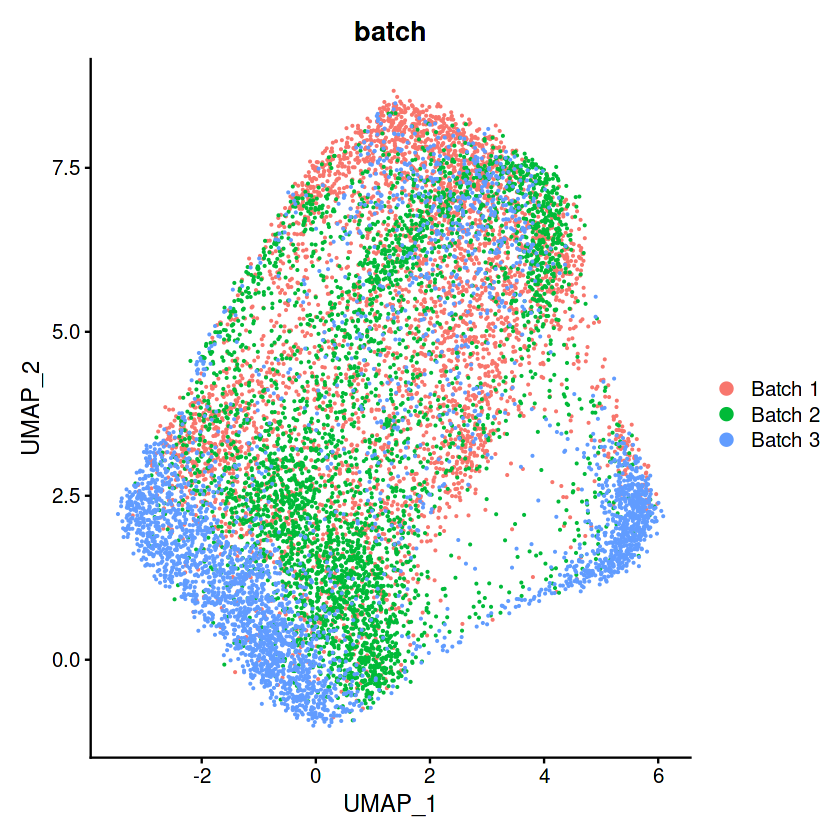

In [80]:
pbmc_batch_sp=CreateSeuratObject(counts = DATA2, min.cells = 0, min.features = 0, project = "ALL") 
pbmc_batch_sp@meta.data$batch=BATCH
pbmc_batch_sp@meta.data$orig.ident=char_layer
pbmc_batch_sp=FindVariableFeatures(object = pbmc_batch_sp, selection.method = "vst", nfeatures = 3000)   
# VariableFeatures(object = pbmc_batch_sp)
pbmc_batch_sp <- NormalizeData(object = pbmc_batch_sp, normalization.method = "LogNormalize", scale.factor = 10000)
pbmc_batch_sp <- ScaleData(object = pbmc_batch_sp, features = VariableFeatures(object = pbmc_batch_sp))
pbmc_batch_sp <- RunPCA(object = pbmc_batch_sp, seed.use=123, npcs=50, features = VariableFeatures(object = pbmc_batch_sp), ndims.print=1,nfeatures.print=1)
pbmc_batch_sp <- RunUMAP(pbmc_batch_sp, dims = 1:50, seed.use = 123,n.components=2, umap.method = "umap-learn",  metric="correlation")
DimPlot(pbmc_batch_sp, reduction='umap', group.by='batch', pt.size=0.1)

pbmc_batch_sp_def <- pbmc_batch_sp

In [81]:
pbmc_batch_sp <- RunHarmony(pbmc_batch_sp, 'batch')

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [82]:
pbmc_batch_sp <- FindNeighbors(object = pbmc_batch_sp, reduction='harmony')

Computing nearest neighbor graph

Computing SNN



In [83]:
pbmc_batch_sp <- FindClusters(object = pbmc_batch_sp, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11880
Number of edges: 350123

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8043
Number of communities: 7
Elapsed time: 2 seconds


In [84]:
pbmc_batch_sp_def <- FindNeighbors(object = pbmc_batch_sp_def, reduction='pca')

Computing nearest neighbor graph

Computing SNN



In [92]:
pbmc_batch_sp_def <- FindClusters(object = pbmc_batch_sp_def, resolution = 0.4)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11880
Number of edges: 352641

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8263
Number of communities: 7
Elapsed time: 2 seconds


In [49]:
file_name = paste0(dataset_folder, '/samples/Harmony_sp_', save_data_name,'.h5Seurat')
SaveH5Seurat(pbmc_batch_sp, filename = file_name)
Convert(file_name, dest = "h5ad")
print(paste0('saved to ',file_name))

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

Adding variable features for RNA

Adding feature-level metadata for RNA

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Adding cell embeddings for harmony

Adding loadings for harmony

Adding projected loadings for harmony

Adding standard deviations for harmony

No JackStraw data for harmony

Validating h5Seurat file

Adding scale.data from RNA as X

Transfering meta.features to var

Adding data from RNA as raw

Transfering meta.features to raw/var

Transfering meta.data to obs

Adding dimensional reduction information for harmony

Adding feature loadings for harmony

Adding dimensional reduction information for pca

Addi

[1] "saved to /workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/dataset/samples/Harmony_sp_embed_all_coronal.h5Seurat"


In [86]:
listings = pbmc_batch_sp@meta.data[['batch']]
numbered_list <- as.integer(factor(listings, levels = unique(listings)))
batch_numeric <- numbered_list
names(batch_numeric) <- colnames(x=pbmc_batch_sp)
pbmc_batch_sp<- AddMetaData(
    object = pbmc_batch_sp,
    metadata = batch_numeric,
    col.name = 'batch_numeric'
    )
# head(x=pbmc)

In [87]:
listings = pbmc_batch_sp@meta.data[['orig.ident']]
numbered_list <- as.integer(factor(listings, levels = unique(listings)))
ident_numeric <- numbered_list
names(ident_numeric) <- colnames(x=pbmc_batch_sp)
pbmc_batch_sp<- AddMetaData(
    object = pbmc_batch_sp,
    metadata = ident_numeric,
    col.name = 'ident_numeric'
    )
# head(x=pbmc)

In [88]:
nona_batch_sp <- pbmc_batch_sp[,!is.na(pbmc_batch_sp$orig.ident)]
nona_batch_sp

An object of class Seurat 
67076 features across 11720 samples within 1 assay 
Active assay: RNA (67076 features, 3000 variable features)
 3 dimensional reductions calculated: pca, umap, harmony

In [89]:
na_filled_sp <- list()
for (batch in unique(nona_batch_sp$batch)){
    na_filled_sp[[batch]] <- nona_batch_sp[, nona_batch_sp$batch==batch]
}
names(na_filled_sp)

[1] "Batch 1" "Batch 2" "Batch 3"

In [93]:
nona_batch_sp_def <- pbmc_batch_sp_def[,!is.na(pbmc_batch_sp_def$orig.ident)]
nona_batch_sp_def

An object of class Seurat 
67076 features across 11720 samples within 1 assay 
Active assay: RNA (67076 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

In [94]:
na_filled_sp_def <- list()
for (batch in unique(nona_batch_sp_def$batch)){
    na_filled_sp_def[[batch]] <- nona_batch_sp_def[, nona_batch_sp_def$batch==batch]
}
names(na_filled_sp)

[1] "Batch 1" "Batch 2" "Batch 3"

<h1>END of process, optional performance metric and visualization below</h1>

<H2>ARI and NMI Scores</H2>

<h3>Integrated, with spatial info, with BEER</h3>

In [25]:
score <- ARI(pbmc_nona_var$seurat_clusters,pbmc_nona_var$orig.ident)
print(c('combined ARI score: ', score))

[1] "combined ARI score: " "0.25300821641698"    


In [26]:
for (key in names(na_filled)){
    ARI_score <- ARI(na_filled[[key]]$seurat_clusters, na_filled[[key]]$orig.ident)
    print(paste0(key, ' ARI score: ', ARI_score))
    }

[1] "Batch 1 ARI score: 0.249585382564554"
[1] "Batch 2 ARI score: 0.274668017333407"
[1] "Batch 3 ARI score: 0.386884300555774"


In [27]:
for (key in names(na_filled)){
    NMI_score <- NMI(na_filled[[key]]$seurat_clusters, na_filled[[key]]$orig.ident)
    print(paste0(key, ' NMI score: ', NMI_score))
    }

[1] "Batch 1 NMI score: 0.331202253077731"
[1] "Batch 2 NMI score: 0.335811534736902"
[1] "Batch 3 NMI score: 0.418705956250615"


<h3>Integrated, no spatial info, with Harmony</h3>

In [62]:
score <- ARI(nona_batch$seurat_clusters, nona_batch$orig.ident)
print(c('before batch effect removal combined ARI score: ', score))

[1] "before batch effect removal combined ARI score: "
[2] "0.152974664826773"                               


In [63]:
for (key in names(na_filled_harmony)){
    ARI_score <- ARI(na_filled_harmony[[key]]$seurat_clusters, na_filled_harmony[[key]]$orig.ident)
    print(paste0(key, ' ARI score: ', ARI_score))
    }

[1] "Batch 1 ARI score: 0.195507814829229"
[1] "Batch 2 ARI score: 0.184688065624757"
[1] "Batch 3 ARI score: 0.213464996046618"


In [64]:
for (key in names(na_filled_harmony)){
    NMI_score <- NMI(na_filled_harmony[[key]]$seurat_clusters, na_filled_harmony[[key]]$orig.ident)
    print(paste0(key, ' NMI score: ', NMI_score))
    }

[1] "Batch 1 NMI score: 0.255639427274037"
[1] "Batch 2 NMI score: 0.184221576886738"
[1] "Batch 3 NMI score: 0.295418851349048"


<h3>Integrated, no spatial info, no Harmony</h3>

In [47]:
score <- ARI(nona_batch_default$seurat_clusters, nona_batch_default$orig.ident)
print(c('before batch effect removal combined ARI score: ', score))

[1] "before batch effect removal combined ARI score: "
[2] "0.166154785399512"                               


In [48]:
for (key in names(na_filled_default)){
    ARI_score <- ARI(na_filled_default[[key]]$seurat_clusters, na_filled_default[[key]]$orig.ident)
    print(paste0(key, ' ARI score: ', ARI_score))
    }

[1] "Batch 1 ARI score: 0.25502040118585"
[1] "Batch 2 ARI score: 0.179005170773573"
[1] "Batch 3 ARI score: 0.225855958302328"


In [49]:
for (key in names(na_filled_default)){
    NMI_score <- NMI(na_filled_default[[key]]$seurat_clusters, na_filled_default[[key]]$orig.ident)
    print(paste0(key, ' NMI score: ', NMI_score))
    }

[1] "Batch 1 NMI score: 0.324294935966775"
[1] "Batch 2 NMI score: 0.228485536627006"
[1] "Batch 3 NMI score: 0.328868411875122"


<h3>Integrated, with spatial info, no Harmony</h3>

In [95]:
score <- ARI(nona_batch_sp$seurat_clusters, nona_batch_sp$orig.ident)
print(c('before batch effect removal combined ARI score: ', score))

[1] "before batch effect removal combined ARI score: "
[2] "0.177483585584368"                               


In [96]:
for (key in names(na_filled_sp)){
    ARI_score <- ARI(na_filled_sp[[key]]$seurat_clusters, na_filled_sp[[key]]$orig.ident)
    print(paste0(key, ' ARI score: ', ARI_score))
    }

[1] "Batch 1 ARI score: 0.166922753437737"
[1] "Batch 2 ARI score: 0.21335798716235"
[1] "Batch 3 ARI score: 0.288027188858489"


In [97]:
for (key in names(na_filled_sp)){
    NMI_score <- NMI(na_filled_sp[[key]]$seurat_clusters, na_filled_sp[[key]]$orig.ident)
    print(paste0(key, ' NMI score: ', NMI_score))
    }

[1] "Batch 1 NMI score: 0.264754770227036"
[1] "Batch 2 NMI score: 0.27102990162924"
[1] "Batch 3 NMI score: 0.386365639427826"


<h3>Integrated, with spatial info, with Harmony</h3>

In [98]:
score <- ARI(nona_batch_sp_def$seurat_clusters, nona_batch_sp_def$orig.ident)
print(c('before batch effect removal combined ARI score: ', score))

[1] "before batch effect removal combined ARI score: "
[2] "0.146015850401216"                               


In [99]:
for (key in names(na_filled_sp_def)){
    ARI_score <- ARI(na_filled_sp_def[[key]]$seurat_clusters, na_filled_sp_def[[key]]$orig.ident)
    print(paste0(key, ' ARI score: ', ARI_score))
    }

[1] "Batch 1 ARI score: 0.209121121870099"
[1] "Batch 2 ARI score: 0.118322786991793"
[1] "Batch 3 ARI score: 0.293938078743003"


In [100]:
for (key in names(na_filled_sp_def)){
    NMI_score <- NMI(na_filled_sp_def[[key]]$seurat_clusters, na_filled_sp_def[[key]]$orig.ident)
    print(paste0(key, ' NMI score: ', NMI_score))
    }

[1] "Batch 1 NMI score: 0.323951839854669"
[1] "Batch 2 NMI score: 0.259281380864382"
[1] "Batch 3 NMI score: 0.388246227576476"


<h2>Visualizations</h2>

<h3>Integrated, with spatial info, with BEER</h3>

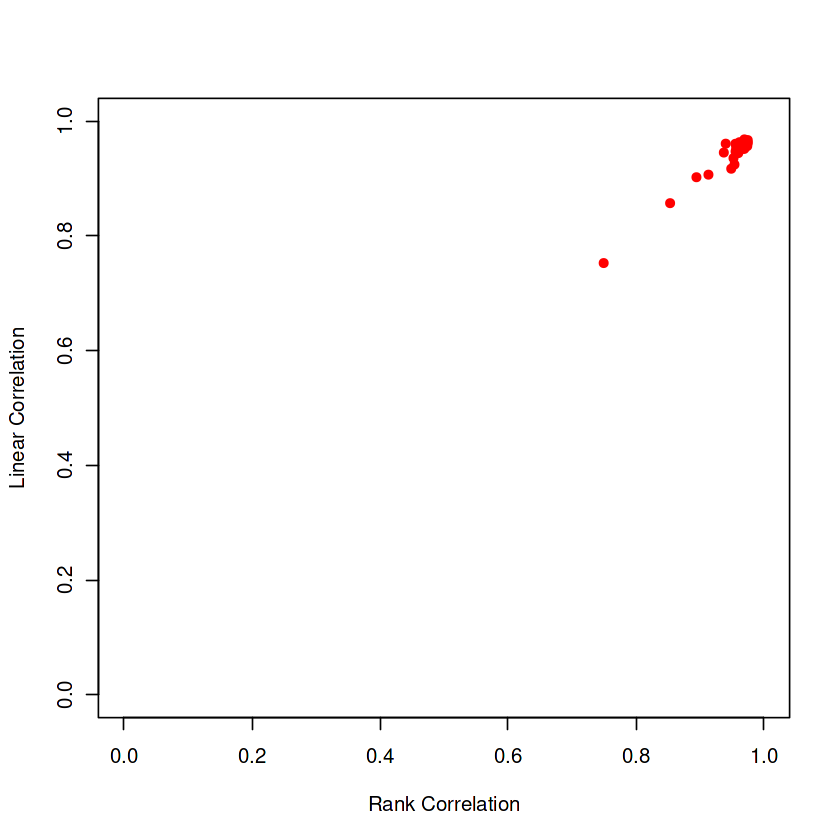

In [50]:
PCUSE=mybeer$select
COL=rep('black',length(mybeer$cor))
COL[PCUSE]='red'
plot(mybeer$cor,mybeer$lcor,pch=16,col=COL,
    xlab='Rank Correlation',ylab='Linear Correlation',xlim=c(0,1),ylim=c(0,1))

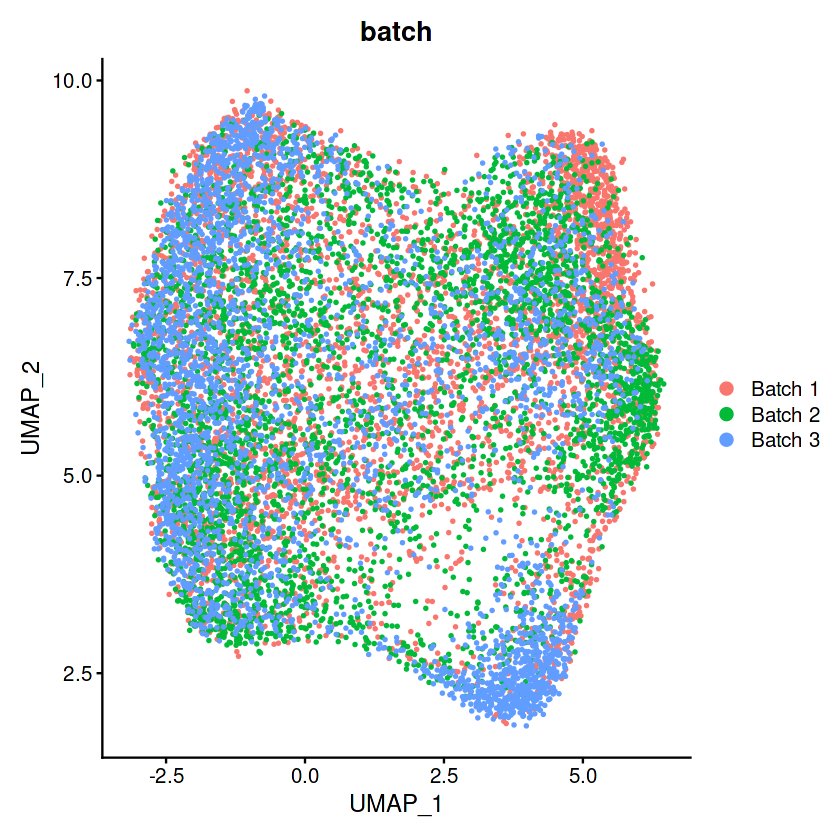

In [51]:
DimPlot(pbmc, reduction='umap', group.by='batch', pt.size=0.5)  

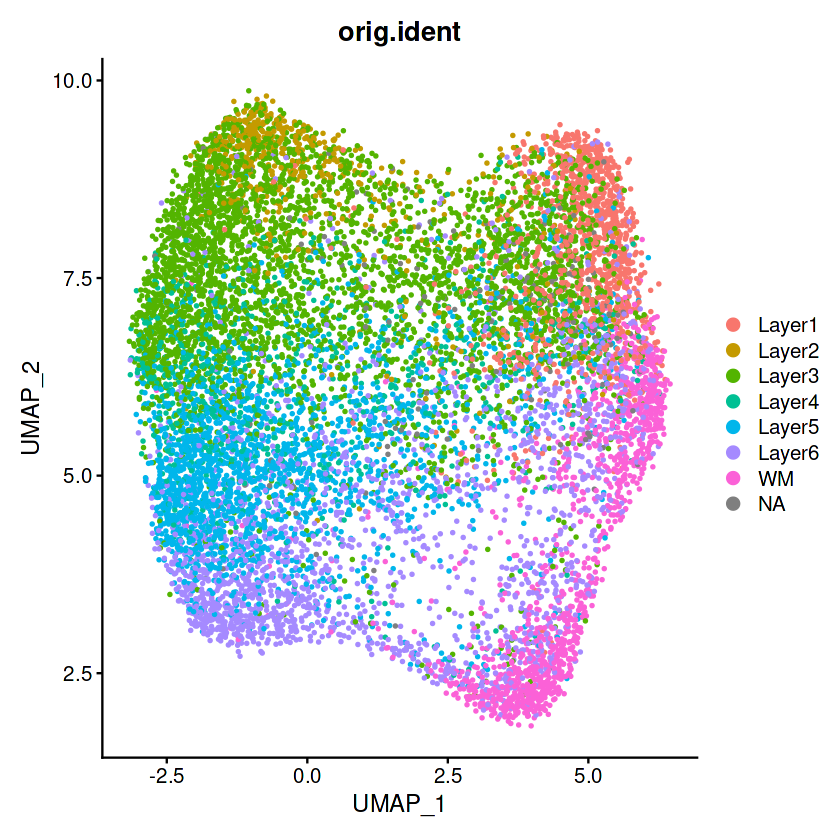

In [52]:
DimPlot(pbmc, reduction='umap', group.by='orig.ident', pt.size=0.5)  

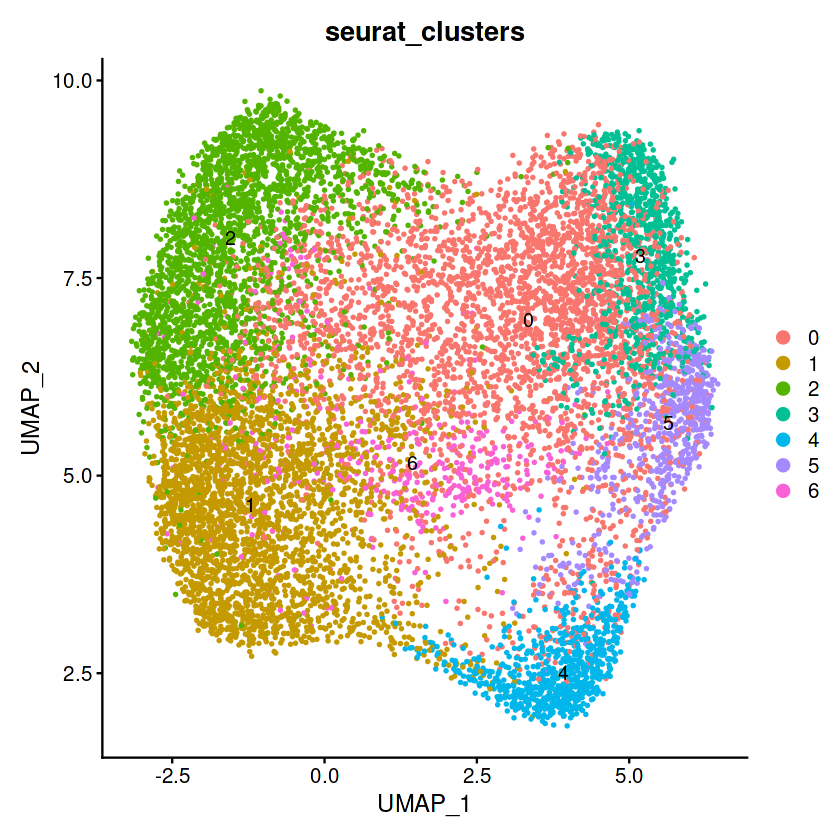

In [53]:
plot_save <- DimPlot(pbmc, reduction='umap', group.by='seurat_clusters', pt.size=0.5, label=TRUE)
plot_save
# ggsave('Clustering_output.png',plot_save)

<h3>Integrated, without spatial info, without BEER</h3>

In [54]:
plot1 <- DimPlot(pbmc_batch, reduction='umap', group.by='orig.ident', pt.size=0.1)
plot2 <- DimPlot(pbmc_batch, reduction='umap', group.by='seurat_clusters', pt.size=0.1) 

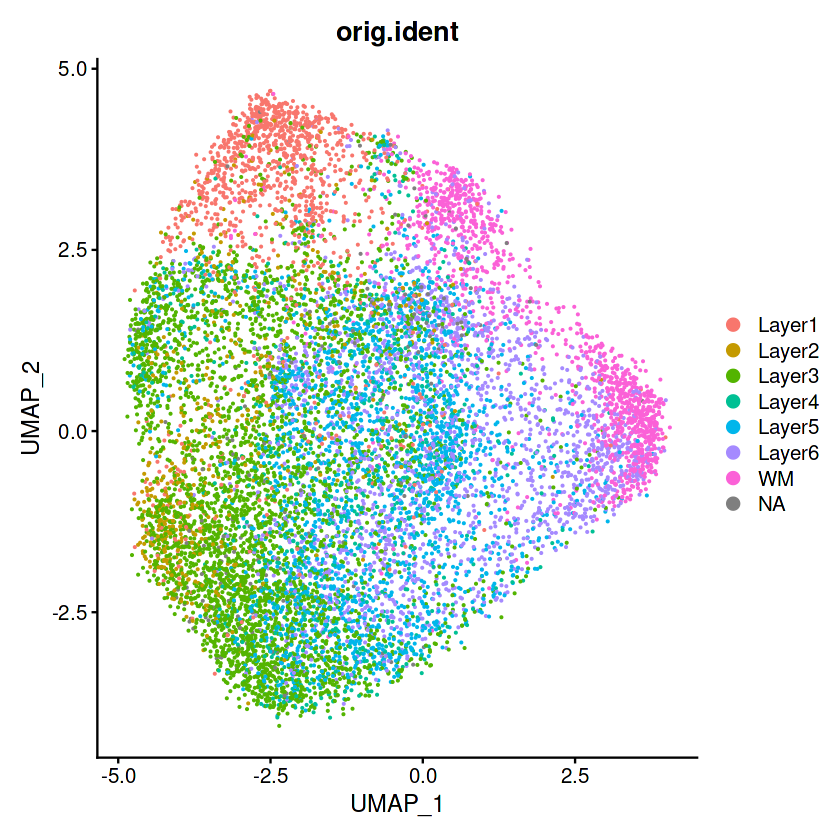

In [55]:
plot1

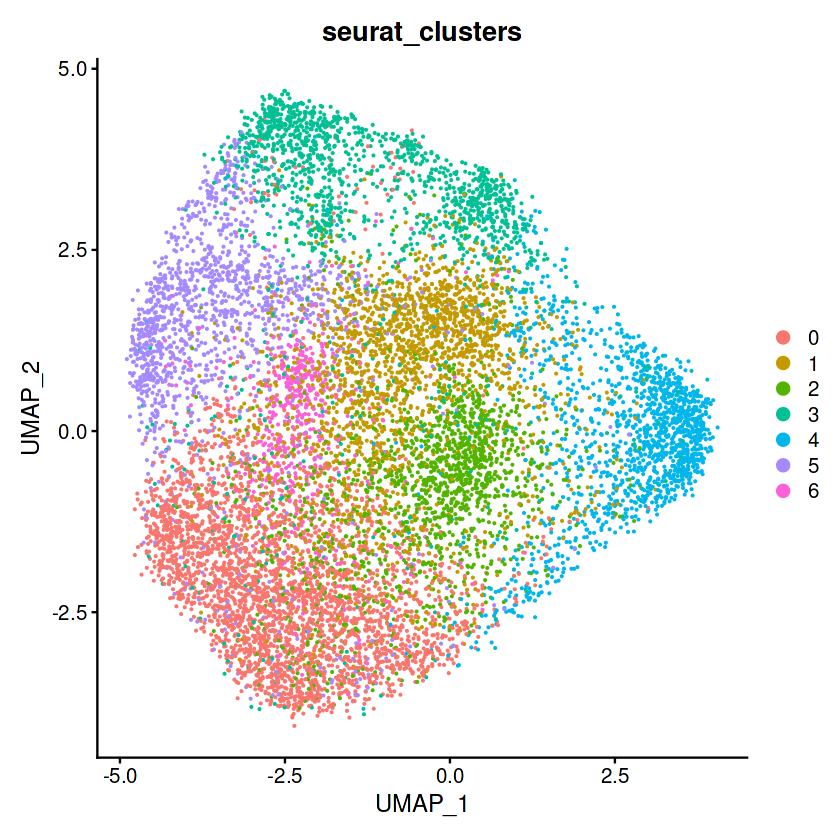

In [56]:
plot2

In [57]:
plot3 <- DimPlot(pbmc_batch, reduction='harmony', group.by='orig.ident', pt.size=0.1)
plot4 <- DimPlot(pbmc_batch, reduction='harmony', group.by='seurat_clusters', pt.size=0.1) 

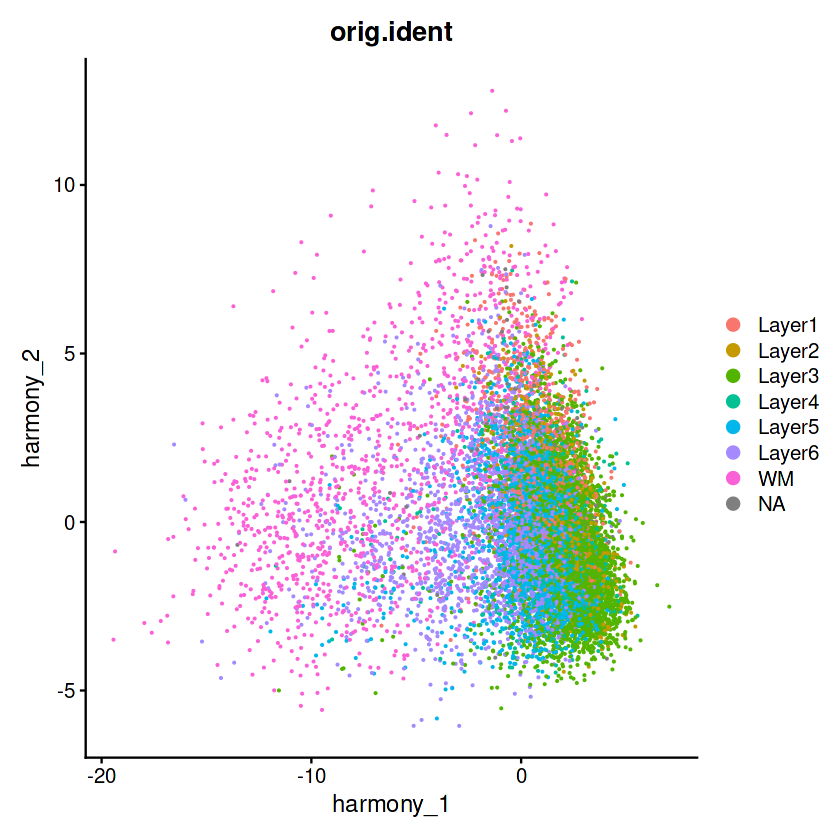

In [58]:
plot3

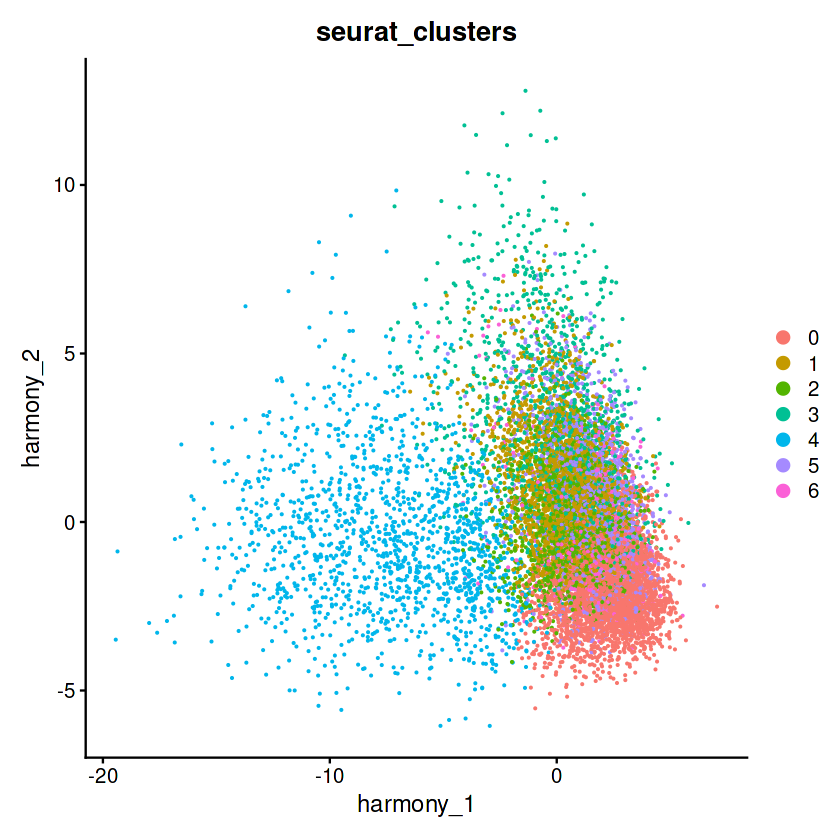

In [59]:
plot4

<h3>Integrated, with spatial info, without BEER</h3>

In [50]:
plot1 <- DimPlot(pbmc_batch_sp, reduction='umap', group.by='orig.ident', pt.size=0.1)
plot2 <- DimPlot(pbmc_batch_sp, reduction='umap', group.by='seurat_clusters', pt.size=0.1) 

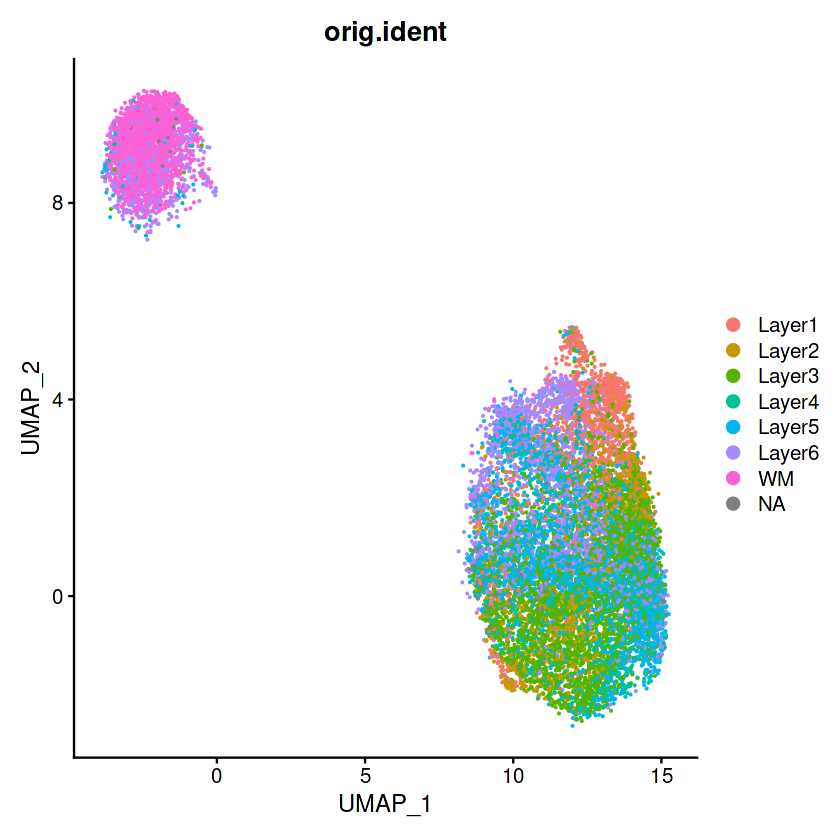

In [51]:
plot1

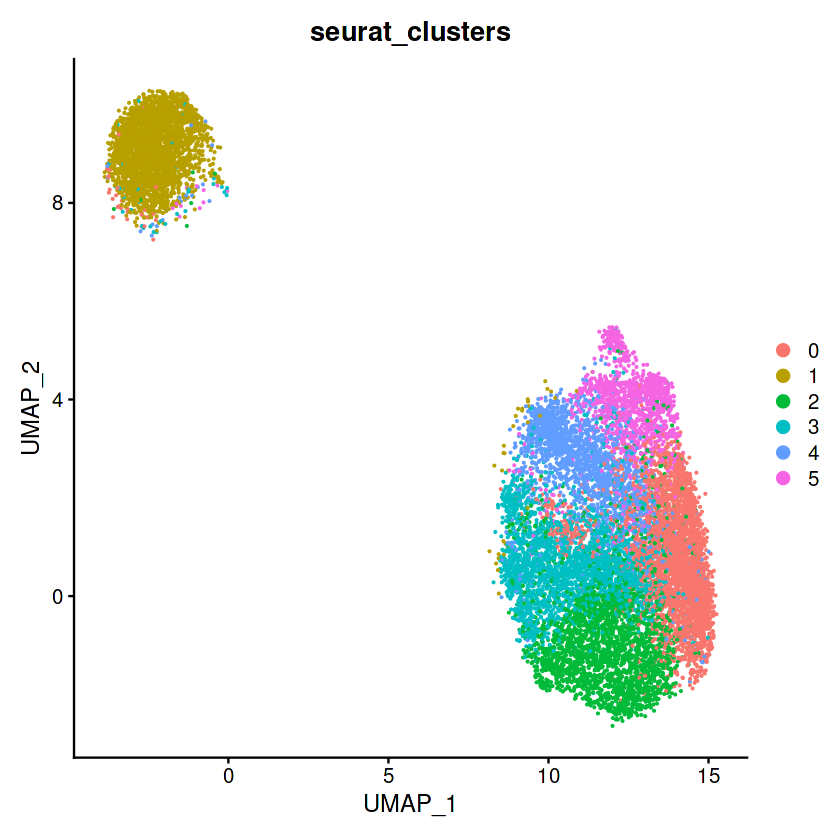

In [52]:
plot2

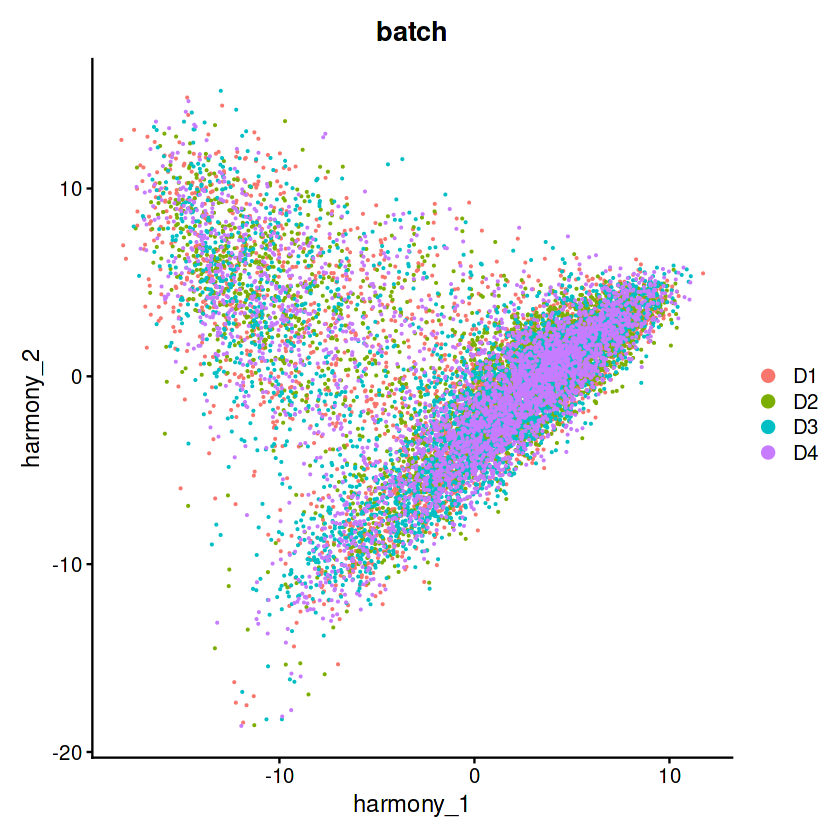

In [101]:
# pbmc_batch_sp <- RunUMAP(pbmc_batch_sp, reduction="harmony")
DimPlot(pbmc_batch_sp, reduction='harmony', group.by='batch', pt.size=0.1) 

In [107]:
plot3 <- DimPlot(pbmc_batch_sp, reduction='harmony', group.by='orig.ident', pt.size=0.1)
plot4 <- DimPlot(pbmc_batch_sp, reduction='harmony', group.by='seurat_clusters', pt.size=0.1) 

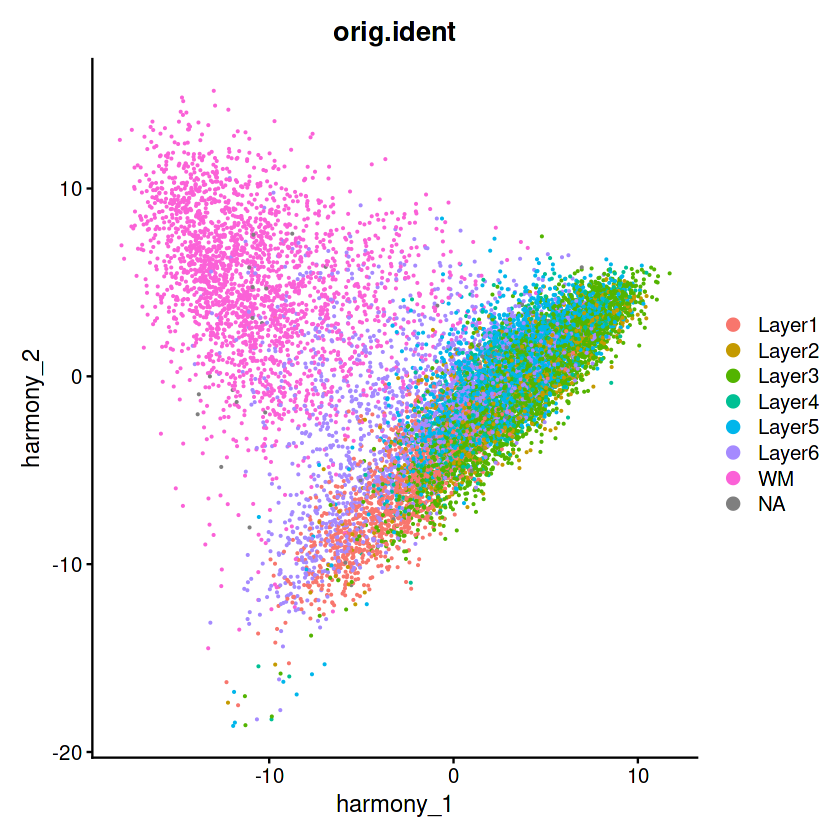

In [108]:
plot3

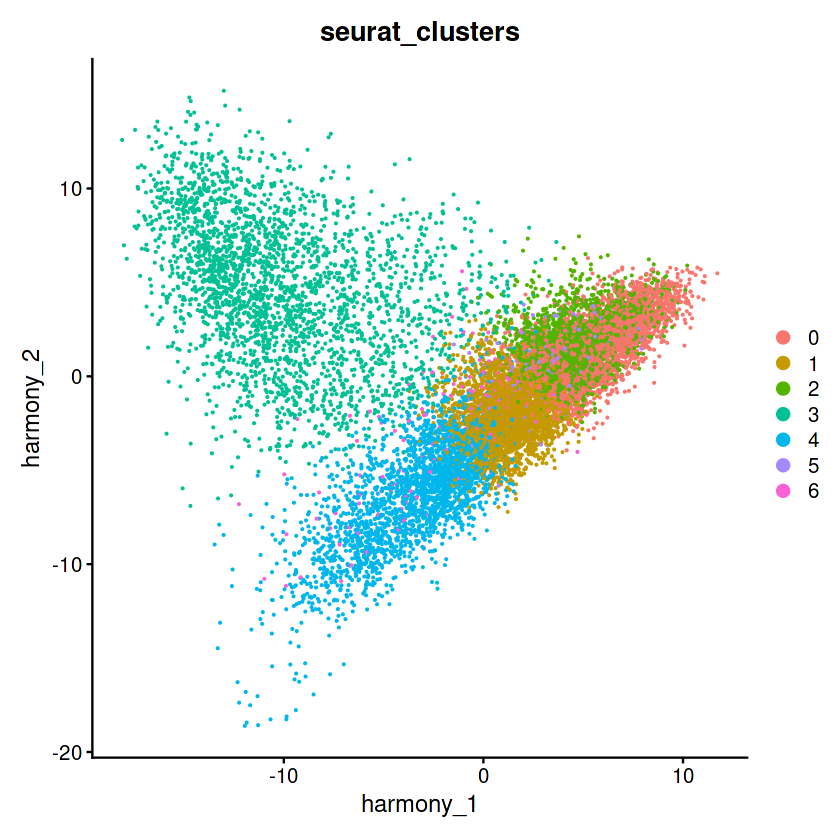

In [109]:
plot4

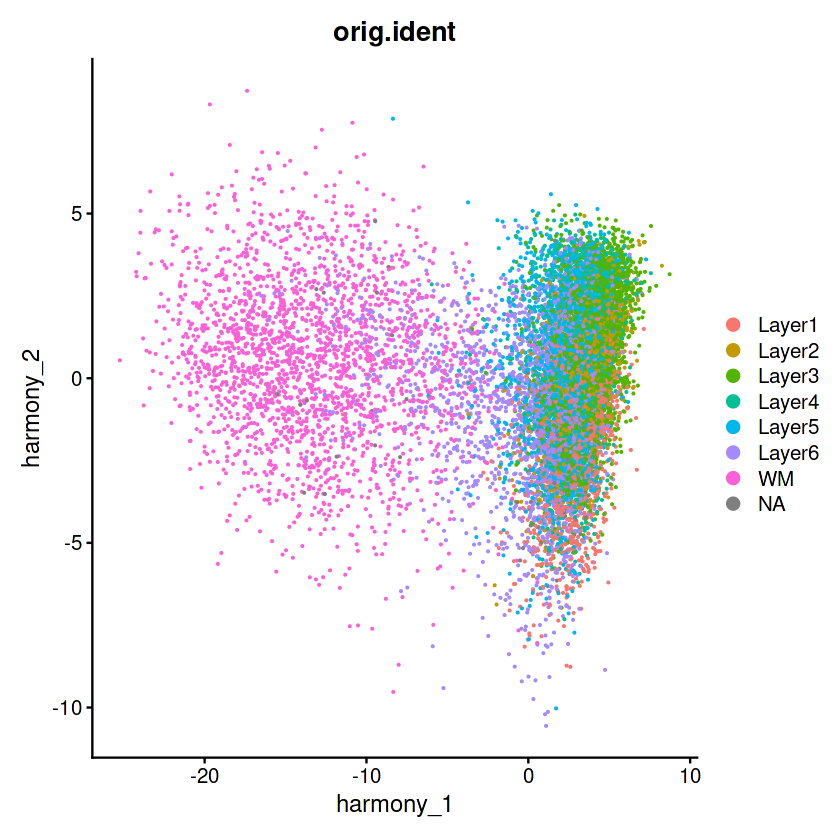

In [63]:
plot3

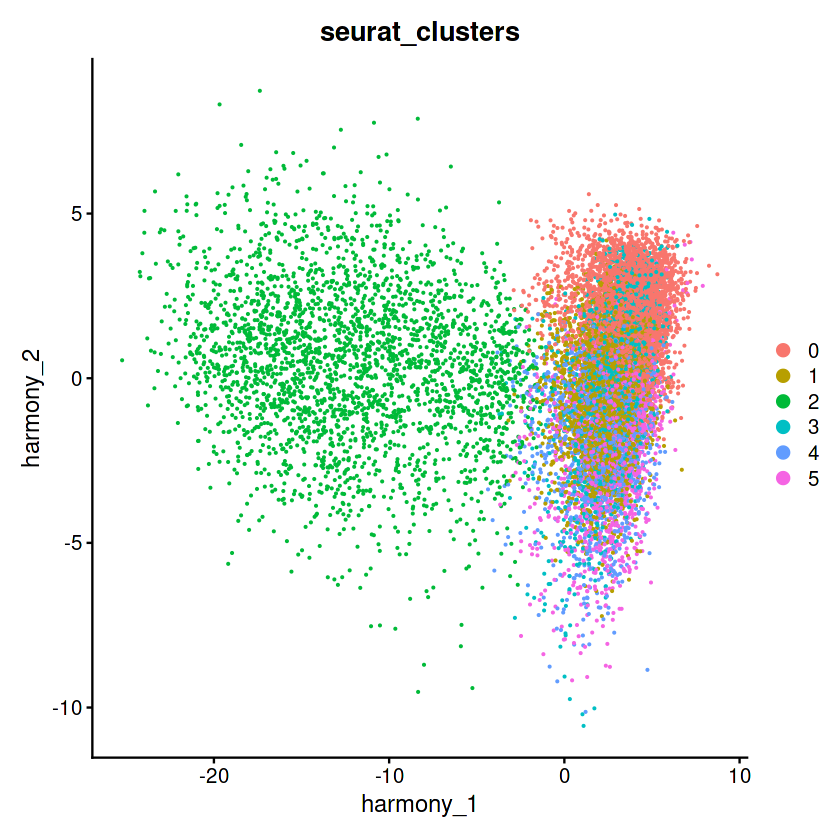

In [64]:
plot4

<h2>Integrated w/ spatial w/ Batch Effect Removal Visualization</h2>

### Helper Functions:
1. Download Image Data
   * Downloads the image, scalefactors, and the tissue positions. See Fetch_Data.ipynb.
2. Add Image Data to Seurat Object.
   * Add an image to a Seurat Object.
   * Create a Spatial assay for the seurat object first before attaching the image.
3. SpatiallyVariableFeatures_workaround
   * Current implementation of SpatiallyVariableFeatures does not work. See https://github.com/satijalab/seurat/issues/7034
   * Only to be used if necessary for downstream analysis.

In [73]:
# Function for attaching image to Seurat Object
addImage <- function(object, sample_id, path, new_name=NULL) {
    image_dir <- file.path(path, sample_id)
    img <- Seurat::Read10X_Image(image.dir = image_dir)
    Seurat::DefaultAssay(object = img) <- 'Spatial'
    img <- img[colnames(x = object)]
    if (is.null(new_name)) {
        object[['image']] <- img
    } else {
        print(new_name)
        object[[new_name]] <- img
    }
    return(object)
}

In [74]:
# Using a workaround for now - https://github.com/satijalab/seurat/issues/7422
SpatiallyVariableFeatures_workaround <- function(object, assay="SCT", selection.method = "moransi") {
  #' This is work around function to replace SeuratObject::SpatiallyVariableFeatures function.
  #' return ranked list of Spatially Variable Features
  
  # Check if object is a Seurat object
  if (!inherits(object, "Seurat")) {
    stop("object must be a Seurat object")
  }

  # Check if assay is a valid assay
  if (!assay %in% names(object@assays)) {
    stop("assay must be a valid assay")
  }
  
  # Extract meta.features from the specified object and assay
  data <- object@assays[[assay]]@meta.features
  
  # Select columns starting with the provided col_prefix
  moransi_cols <- grep(paste0("^", selection.method), colnames(data), value = TRUE)

  # Filter rows where "moransi.spatially.variable" is TRUE
  filtered_data <- data[data[[paste0(selection.method, ".spatially.variable")]], moransi_cols]

  # Sort filtered data by "moransi.spatially.variable.rank" column in ascending order
  sorted_data <- filtered_data[order(filtered_data[[paste0(selection.method, ".spatially.variable.rank")]]), ]
    
  # Return row names of the sorted data frame
  rownames(sorted_data)
}

In [ ]:
D1_corrected <- pbmc_nona_var[,pbmc_nona_var$batch=='D1']
D2_corrected <- pbmc_nona_var[,pbmc_nona_var$batch=='D2']
D3_corrected <- pbmc_nona_var[,pbmc_nona_var$batch=='D3']

In [75]:
removeColnameSuffix <- function(colname) {
    if (endsWith(colname, ".1") || endsWith(colname, ".2")) {
        return(gsub('.{2}$', '', colname))
    }
    return(colname)
}

In [95]:
for (key in names(na_filled)){
    new_colnames <- lapply(colnames(na_filled[[key]]), removeColnameSuffix)
    new_colnames <- simplify2array(new_colnames)
    na_filled[[key]] <- RenameCells(na_filled[[key]], new.names = new_colnames)
    
    corrected_spatial_assay <- CreateAssayObject(counts = na_filled[[key]][["RNA"]]@data)
    na_filled[[key]][["Spatial"]] <- corrected_spatial_assay
}

In [ ]:
D1_corrected_spatial_assay <- CreateAssayObject(counts = D1_corrected[["RNA"]]@data)
D1_corrected[["Spatial"]] <- D1_corrected_spatial_assay
D2_corrected_spatial_assay <- CreateAssayObject(counts = D2_corrected[["RNA"]]@data)
D2_corrected[["Spatial"]] <- D2_corrected_spatial_assay
D3_corrected_spatial_assay <- CreateAssayObject(counts = D3_corrected[["RNA"]]@data)
D3_corrected[["Spatial"]] <- D3_corrected_spatial_assay

In [97]:
# Set the download dir to the directory where the image information of the samples are downloaded. "dataset/samples"
data_dir <- 'dataset'
sample_dir <- 'samples'
download_dir <- file.path(data_dir, sample_dir)

In [ ]:
sample_674_name <- '151507'
D1_corrected <- addImage(D1_corrected, sample_674_name, download_dir, new_name=glue("image{sample_674_name}"))
sample_675_name <- '151672'
D2_corrected <- addImage(D2_corrected, sample_675_name, download_dir, new_name=glue("image{sample_675_name}"))
sample_674_name <- '151674'
D3_corrected <- addImage(D3_corrected, sample_674_name, download_dir, new_name=glue("image{sample_674_name}"))

In [ ]:
DefaultAssay(D1_corrected) <- "Spatial"
DefaultAssay(D2_corrected) <- "Spatial"
DefaultAssay(D3_corrected) <- "Spatial"

In [ ]:
D1_corrected
D2_corrected
D3_corrected

In [ ]:
D1_corrected
D2_corrected
D3_corrected

In [ ]:
# Adjust plot size
options(repr.plot.width = 30, repr.plot.height = 10)

In [ ]:
D1_corrected_plot_ncount <- SpatialFeaturePlot(D1_corrected, features = "nCount_Spatial") + theme(legend.position = "right")
D1_corrected_plot_layers <- SpatialDimPlot(D1_corrected, group.by='orig.ident', label = TRUE, label.size = 9) + theme(legend.position = "right")
D1_corrected_plot_seurat <- SpatialDimPlot(D1_corrected, group.by='seurat_clusters', label = TRUE, label.size = 9) + theme(legend.position = "right")
wrap_plots(D1_corrected_plot_ncount, D1_corrected_plot_layers, D1_corrected_plot_seurat)

In [ ]:
g <- ggplot_build(D1_corrected_plot_layers)
cols <- unique(g$data[[1]]["fill"])
barplot(c(5,5,5,5,5,5,5), col = c(cols[1,1], cols[2,1], cols[3,1], cols[4,1], cols[5,1], cols[6,1], cols[7,1] ))

In [ ]:
layers_col <- c('WM'=cols[3,1], 'Layer1'=cols[1,1] ,'Layer2'=cols[6,1], 'Layer3'=cols[2,1], 'Layer4'=cols[7,1], 'Layer5'=cols[5,1], 'Layer6'=cols[4,1])
colors_674 <- c('4'=cols[3,1], '3'=cols[1,1], '6'=cols[6,1], '2'=cols[2,1], '0'=cols[7,1], '1'=cols[5,1], '5'=cols[4,1])
colors_675 <- c('5'=cols[3,1], '3'=cols[1,1], '2'=cols[6,1], '0'=cols[2,1], '6'=cols[7,1], '1'=cols[5,1], '4'=cols[4,1])
colors_674 <- c('4'=cols[3,1], '3'=cols[1,1], '5'=cols[6,1], '2'=cols[2,1], '6'=cols[7,1], '1'=cols[5,1], '0'=cols[4,1]) 

In [ ]:
layers_col <- c('WM'=cols[3,1], 'Layer1'=cols[1,1] ,'Layer2'=cols[6,1], 'Layer3'=cols[2,1], 'Layer4'=cols[7,1], 'Layer5'=cols[5,1], 'Layer6'=cols[4,1])
b_colors_674 <- c('5'=cols[3,1], '4'=cols[1,1] ,'3'=cols[6,1], '1'=cols[2,1], '2'=cols[7,1], '0'=cols[5,1], '6'=cols[4,1])
b_colors_675 <- c('6'=cols[3,1], '4'=cols[1,1] ,'5'=cols[6,1], '1'=cols[2,1], '3'=cols[7,1], '2'=cols[5,1], '0'=cols[4,1])
b_colors_674 <- c('5'=cols[3,1], '4'=cols[1,1] ,'3'=cols[6,1], '1'=cols[2,1], '6'=cols[7,1], '0'=cols[5,1], '2'=cols[4,1]) 

In [ ]:
to_test <- colnames(D3_nona[ ,D3_nona$orig.ident=="Layer1"])
for (i in unique(D3_nona$seurat_clusters)){
score <- jaccard(to_test, colnames(D3_nona[ ,D3_nona$seurat_clusters==i]))
print(paste0(i, " - ",score))
}

In [ ]:
to_test <- colnames(D3_nospatial_nocorrection[ ,D3_nospatial_nocorrection$orig.ident=="Layer4"])
for (i in unique(D3_nospatial_nocorrection$seurat_clusters)){
score <- jaccard(to_test, colnames(D3_nospatial_nocorrection[ ,D3_nospatial_nocorrection$seurat_clusters==i]))
print(paste0(i, " - ",score))
}

In [ ]:
to_test <- colnames(D3_nospatial_nocorrection[ ,D3_nospatial_nocorrection$seurat_clusters=='6'])
for (i in unique(D3_nospatial_nocorrection$orig.ident)){
score <- jaccard(colnames(D3_nospatial_nocorrection[ ,D3_nospatial_nocorrection$orig.ident==i]), to_test)
print(paste0(i, " - ",score))
}

In [ ]:
D3_corrected_plot_ncount <- SpatialFeaturePlot(D3_corrected, features = "nCount_Spatial") + theme(legend.position = "right")
D3_corrected_plot_layers <- SpatialDimPlot(D3_corrected, group.by='orig.ident', label = TRUE, label.size = 7, image.alpha=0.3) + theme(legend.position = "right") + scale_fill_manual(values = layers_col)
D3_corrected_plot_seurat <- SpatialDimPlot(D3_corrected, group.by='seurat_clusters', label = TRUE, label.size = 7, image.alpha=0.3) + theme(legend.position = "right") + scale_fill_manual(values = colors_674)
wrap_plots(D3_corrected_plot_ncount, D3_corrected_plot_layers, D3_corrected_plot_seurat)

In [ ]:
# ggsave('Clustering_675_nolabel.png',D2_corrected_plot_seurat)

In [ ]:
D1_corrected_plot_ncount <- SpatialFeaturePlot(D1_corrected, features = "nCount_Spatial") + theme(legend.position = "right")
D1_corrected_plot_layers <- SpatialDimPlot(D1_corrected, group.by='orig.ident', label = TRUE, label.size = 7) + theme(legend.position = "right") + scale_fill_manual(values = layers_col)
D1_corrected_plot_seurat <- SpatialDimPlot(D1_corrected, group.by='seurat_clusters', label = TRUE, label.size = 7) + theme(legend.position = "right") + scale_fill_manual(values = colors_674)
wrap_plots(D1_corrected_plot_ncount, D1_corrected_plot_layers, D1_corrected_plot_seurat)

In [ ]:
D1_corrected_plot_ncount <- SpatialFeaturePlot(D1_corrected, features = "nCount_Spatial") + theme(legend.position = "right")
D1_corrected_plot_layers <- SpatialDimPlot(D1_corrected, group.by='orig.ident', label = TRUE, label.size = 7) + theme(legend.position = "right")
D1_corrected_plot_seurat <- SpatialDimPlot(D1_corrected, group.by='seurat_clusters', label = TRUE, label.size = 7) + theme(legend.position = "right")
wrap_plots(D1_corrected_plot_ncount, D1_corrected_plot_layers, D1_corrected_plot_seurat)

In [ ]:
D2_corrected_plot_ncount <- SpatialFeaturePlot(D2_corrected, features = "nCount_Spatial") + theme(legend.position = "right")
D2_corrected_plot_layers <- SpatialDimPlot(D2_corrected, group.by='orig.ident', label = TRUE, label.size = 7) + theme(legend.position = "right") + scale_fill_manual(values = layers_col)
D2_corrected_plot_seurat <- SpatialDimPlot(D2_corrected, group.by='seurat_clusters', label = TRUE, label.size = 7) + theme(legend.position = "right") + scale_fill_manual(values = colors_675)
wrap_plots(D2_corrected_plot_ncount, D2_corrected_plot_layers, D2_corrected_plot_seurat)

In [ ]:
D2_corrected_plot_ncount <- SpatialFeaturePlot(D2_corrected, features = "nCount_Spatial") + theme(legend.position = "right")
D2_corrected_plot_layers <- SpatialDimPlot(D2_corrected, group.by='orig.ident', label = TRUE, label.size = 7) + theme(legend.position = "right")
D2_corrected_plot_seurat <- SpatialDimPlot(D2_corrected, group.by='seurat_clusters', label = TRUE, label.size = 7) + theme(legend.position = "right")
wrap_plots(D2_corrected_plot_ncount, D2_corrected_plot_layers, D2_corrected_plot_seurat)

In [ ]:
D3_corrected_plot_ncount <- SpatialFeaturePlot(D3_corrected, features = "nCount_Spatial") + theme(legend.position = "right")
D3_corrected_plot_layers <- SpatialDimPlot(D3_corrected, group.by='orig.ident', label = TRUE, label.size = 7) + theme(legend.position = "right") + scale_fill_manual(values = layers_col)
D3_corrected_plot_seurat <- SpatialDimPlot(D3_corrected, group.by='seurat_clusters', label = TRUE, label.size = 7) + theme(legend.position = "right") + scale_fill_manual(values = colors_674)
wrap_plots(D3_corrected_plot_ncount, D3_corrected_plot_layers, D3_corrected_plot_seurat)

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 10)
subset_plot_1 <- SpatialDimPlot(D3_corrected[, D3_corrected$seurat_clusters == 4],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = colors_674)
subset_plot_2 <- SpatialDimPlot(D3_corrected[, D3_corrected$seurat_clusters == 3],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = colors_674)
subset_plot_3 <- SpatialDimPlot(D3_corrected[, D3_corrected$seurat_clusters == 2],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = colors_674)
wrap_plots(subset_plot_1, subset_plot_2, subset_plot_3) 

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 10)
subset_plot_1 <- SpatialDimPlot(D3_corrected[, D3_corrected$orig.ident == "WM"], crop=FALSE, group.by='orig.ident', label = TRUE, label.size = 7, image.alpha = 0.3) + scale_fill_manual(values = layers_col)
subset_plot_2 <- SpatialDimPlot(D3_corrected[, D3_corrected$orig.ident == "Layer1"],crop=FALSE, group.by='orig.ident', label = TRUE, label.size = 7, image.alpha = 0.3) + scale_fill_manual(values = layers_col)
subset_plot_3 <- SpatialDimPlot(D3_corrected[, D3_corrected$orig.ident == "Layer3"], crop=FALSE, group.by='orig.ident', label = TRUE, label.size = 7, image.alpha = 0.3) + scale_fill_manual(values = layers_col)
wrap_plots(subset_plot_1, subset_plot_2, subset_plot_3) 

In [ ]:
D3_corrected_plot_ncount <- SpatialFeaturePlot(D3_corrected, features = "nCount_Spatial", image = NULL) + theme(legend.position = "right")
D3_corrected_plot_layers <- SpatialDimPlot(D3_corrected, group.by='orig.ident', label = TRUE, label.size = 7) + theme(legend.position = "right")
D3_corrected_plot_seurat <- SpatialDimPlot(D3_corrected, group.by='seurat_clusters', label = TRUE, label.size = 7) + theme(legend.position = "right")
wrap_plots(D3_corrected_plot_ncount, D3_corrected_plot_layers, D3_corrected_plot_seurat)

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 20)
gene1 <- SpatialFeaturePlot(D3_corrected, features = "nCount_Spatial") + theme(legend.position = "right", legend.key.size = unit(2,'cm'), legend.title = element_text(size=14), legend.text = element_text(size=12))
gene2 <- SpatialFeaturePlot(D3_corrected, features = "nCount_RNA") + theme(legend.position = "right", legend.key.size = unit(2,'cm'), legend.title = element_text(size=14), legend.text = element_text(size=12))
gene3 <- SpatialFeaturePlot(D3_corrected, features = "nFeature_Spatial") + theme(legend.position = "right", legend.key.size = unit(2,'cm'), legend.title = element_text(size=14), legend.text = element_text(size=12))
gene4 <- SpatialFeaturePlot(D3_corrected, features = "nFeature_RNA") + theme(legend.position = "right", legend.key.size = unit(2,'cm'), legend.title = element_text(size=14), legend.text = element_text(size=12))
wrap_plots(gene1, gene2, gene3, gene4)
# ENSG00000243485

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 20)
gene1 <- SpatialFeaturePlot(D3_corrected, features = "ENSG00000101439") + theme(legend.position = "right", legend.key.size = unit(1.5,'cm'), legend.title = element_text(size=14), legend.text = element_text(size=12))
gene2 <- SpatialFeaturePlot(D3_corrected, features = "ENSG00000087250") + theme(legend.position = "right", legend.key.size = unit(1.5,'cm'), legend.title = element_text(size=14), legend.text = element_text(size=12))
gene3 <- SpatialFeaturePlot(D3_corrected, features = "ENSG00000120885") + theme(legend.position = "right", legend.key.size = unit(1.5,'cm'), legend.title = element_text(size=14), legend.text = element_text(size=12))
gene4 <- SpatialFeaturePlot(D3_corrected, features = "ENSG00000198763") + theme(legend.position = "right", legend.key.size = unit(1.5,'cm'), legend.title = element_text(size=14), legend.text = element_text(size=12))
gene5 <- SpatialFeaturePlot(D3_corrected, features = "ENSG00000198888") + theme(legend.position = "right", legend.key.size = unit(1.5,'cm'), legend.title = element_text(size=14), legend.text = element_text(size=12))
gene6 <- SpatialFeaturePlot(D3_corrected, features = "ENSG00000198899") + theme(legend.position = "right", legend.key.size = unit(1.5,'cm'), legend.title = element_text(size=14), legend.text = element_text(size=12))

wrap_plots(gene1, gene2, gene3, gene4, gene5, gene6)
# ENSG00000243485

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 20)
wrap_plots(D1_corrected_plot_layers, D2_corrected_plot_layers, D3_corrected_plot_layers, D1_corrected_plot_seurat, D2_corrected_plot_seurat, D3_corrected_plot_seurat, ncol=3, nrow=2)

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 20)
wrap_plots(D1_corrected_plot_layers, D2_corrected_plot_layers, D3_corrected_plot_layers, D1_corrected_plot_seurat, D2_corrected_plot_seurat, D3_corrected_plot_seurat, ncol=3, nrow=2)

In [ ]:
dlfpc.merge <- merge(D1_corrected, D2_corrected)
dlfpc.merge <- merge(dlfpc.merge, D3_corrected)

In [ ]:
pbmc_nona_var@reductions$umap

In [ ]:
dlfpc.merge@reductions

In [ ]:
DefaultAssay(dlfpc.merge) <- "Spatial"

In [ ]:
legend_theme <- theme(legend.title = element_text(size=30), legend.text = element_text(size=20))

In [ ]:
D1_orig <- SpatialDimPlot(dlfpc.merge, label.size=4, images="image_151674", group.by="orig.ident")
D2_orig <- SpatialDimPlot(dlfpc.merge, images="image_151675", group.by="orig.ident")
D3_orig <- SpatialDimPlot(dlfpc.merge, images="image_151674", group.by="orig.ident")
D1_seurat <- SpatialDimPlot(dlfpc.merge, images="image_151674", group.by="seurat_clusters")
D2_seurat <- SpatialDimPlot(dlfpc.merge, images="image_151675", group.by="seurat_clusters")
D3_seurat <- SpatialDimPlot(dlfpc.merge, images="image_151674", group.by="seurat_clusters")

In [ ]:
options(repr.plot.width = 21, repr.plot.height = 14)
wrap_plots(D1_orig, D2_orig, D3_orig, D1_seurat, D2_seurat, D3_seurat, ncol=3)
options(repr.plot.width = 7, repr.plot.height = 7)

In [ ]:
output_dir <- "output"
output_default_nocorr_rna <- "default_nocorr_rna"
output_default_nocorr_sct <- "default_nocorr_sct"
output_spatial_rna <- "spatial_nocorr_rna"
output_spatial_sct <- "spatial_nocorr_sct"
output_default_corrected <- "default_corrected"
output_spatial_corrected <- "spatial_corrected"
output_orig <- "orig"
output_D1 <- "D1_single"
output_D2 <- "D2_single"
output_D3 <- "D3_single"
output_subdirs <- list(output_default_nocorr_rna, output_default_nocorr_sct, 
                    output_spatial_rna, output_spatial_sct, 
                    output_default_corrected, output_spatial_corrected,
                    output_D1, output_D2, output_D3,
                    output_orig)
download_dir <- file.path(data_dir, sample_dir)
if (!file.exists(output_dir)) {
    dir.create(output_dir)
}

for (subdir in output_subdirs) {
    subdir_path <- file.path(output_dir,subdir)
    if (!file.exists(subdir_path)) {
        dir.create(subdir_path)    
    }
}

In [ ]:
orig_path <- file.path(output_dir, output_orig)

jpeg(filename = file.path(orig_path, glue("{output_orig}_151674.jpg")), height = 400, width = 470, quality = 100)
D1_orig
dev.off()
jpeg(filename = file.path(orig_path, glue("{output_orig}_151675.jpg")), height = 400, width = 470, quality = 100)
D2_orig
dev.off()
jpeg(filename = file.path(orig_path, glue("{output_orig}_151674.jpg")), height = 400, width = 470, quality = 100)
D3_orig
dev.off()

In [ ]:
gsi_path <- file.path(output_dir, output_spatial_corrected)

jpeg(filename = file.path(gsi_path, glue("{output_spatial_corrected}_151674.jpg")), height = 400, width = 500, quality = 100)
D1_seurat
dev.off()
jpeg(filename = file.path(gsi_path, glue("{output_spatial_corrected}_151675.jpg")), height = 400, width = 500, quality = 100)
D2_seurat
dev.off()
jpeg(filename = file.path(gsi_path, glue("{output_spatial_corrected}_151674.jpg")), height = 400, width = 500, quality = 100)
D3_seurat
dev.off()

In [ ]:
options(repr.plot.width = 21, repr.plot.height = 7)
SpatialDimPlot(dlfpc.merge, group.by="seurat_clusters")

In [ ]:
length(rownames(dlfpc.merge[["image_151674"]]@coordinates))

<h2>End of Integrated w/ spatial w/ Batch Effect Removal Visualization</h2>

<h2>Integrated w/o spatial info w/o BE Removal Visualization</h2>

In [ ]:
D1_nospatial_nocorrection <- nona_batch[,nona_batch$batch=='D1']
D2_nospatial_nocorrection <- nona_batch[,nona_batch$batch=='D2']
D3_nospatial_nocorrection <- nona_batch[,nona_batch$batch=='D3']

In [ ]:
new_D1_colnames <- lapply(colnames(D1_nospatial_nocorrection), removeColnameSuffix)
new_D1_colnames <- simplify2array(new_D1_colnames)
D1_nospatial_nocorrection <- RenameCells(D1_nospatial_nocorrection, new.names = new_D1_colnames)

In [ ]:
new_D2_colnames <- lapply(colnames(D2_nospatial_nocorrection), removeColnameSuffix)
new_D2_colnames <- simplify2array(new_D2_colnames)
D2_nospatial_nocorrection <- RenameCells(D2_nospatial_nocorrection, new.names = new_D2_colnames)

In [ ]:
new_D3_colnames <- lapply(colnames(D3_nospatial_nocorrection), removeColnameSuffix)
new_D3_colnames <- simplify2array(new_D3_colnames)
D3_nospatial_nocorrection <- RenameCells(D3_nospatial_nocorrection, new.names = new_D3_colnames)

In [ ]:
D1_nospatial_nocorrection[["Spatial"]] <- CreateAssayObject(counts = D1_nospatial_nocorrection[["RNA"]]@data)
D2_nospatial_nocorrection[["Spatial"]] <- CreateAssayObject(counts = D2_nospatial_nocorrection[["RNA"]]@data)
D3_nospatial_nocorrection[["Spatial"]] <- CreateAssayObject(counts = D3_nospatial_nocorrection[["RNA"]]@data)

In [ ]:
sample_674_name <- '151674'
D1_nospatial_nocorrection <- addImage(D1_nospatial_nocorrection, sample_674_name, download_dir, new_name=glue("image_{sample_674_name}"))
sample_675_name <- '151675'
D2_nospatial_nocorrection <- addImage(D2_nospatial_nocorrection, sample_675_name, download_dir, new_name=glue("image_{sample_675_name}"))
sample_674_name <- '151674'
D3_nospatial_nocorrection <- addImage(D3_nospatial_nocorrection, sample_674_name, download_dir, new_name=glue("image_{sample_674_name}"))

In [ ]:
DefaultAssay(D1_nospatial_nocorrection) <- "Spatial"
DefaultAssay(D2_nospatial_nocorrection) <- "Spatial"
DefaultAssay(D3_nospatial_nocorrection) <- "Spatial"

In [ ]:
D1_nospatial_nocorrection
D2_nospatial_nocorrection
D3_nospatial_nocorrection

In [ ]:
D1_nospatial_nocorrection
D2_nospatial_nocorrection
D3_nospatial_nocorrection

In [ ]:
layers_col <- c('WM'=cols[3,1], 'Layer1'=cols[1,1] ,'Layer2'=cols[6,1], 'Layer3'=cols[2,1], 'Layer4'=cols[7,1], 'Layer5'=cols[5,1], 'Layer6'=cols[4,1])
b_colors_674 <- c('5'=cols[3,1], '4'=cols[1,1] ,'3'=cols[6,1], '1'=cols[2,1], '2'=cols[7,1], '0'=cols[5,1], '6'=cols[4,1])
b_colors_675 <- c('6'=cols[3,1], '4'=cols[1,1] ,'5'=cols[6,1], '1'=cols[2,1], '3'=cols[7,1], '2'=cols[5,1], '0'=cols[4,1])
b_colors_674 <- c('5'=cols[3,1], '4'=cols[1,1] ,'3'=cols[6,1], '1'=cols[2,1], '6'=cols[7,1], '0'=cols[5,1], '2'=cols[4,1]) 

In [ ]:
to_test <- colnames(D3_nospatial_nocorrection[ ,D3_nospatial_nocorrection$orig.ident=="Layer2"])
for (i in unique(D3_nospatial_nocorrection$seurat_clusters)){
score <- jaccard(to_test, colnames(D3_nospatial_nocorrection[ ,D3_nospatial_nocorrection$seurat_clusters==i]))
print(paste0(i, " - ",score))
}

In [ ]:
to_test <- colnames(D3_nospatial_nocorrection[ ,D3_nospatial_nocorrection$seurat_clusters=='6'])
for (i in unique(D3_nospatial_nocorrection$orig.ident)){
score <- jaccard(colnames(D3_nospatial_nocorrection[ ,D3_nospatial_nocorrection$orig.ident==i]), to_test)
print(paste0(i, " - ",score))
}

In [ ]:
to_test <- colnames(D3_corrected[ ,D3_corrected$orig.ident=="Layer2"])
for (i in unique(D3_corrected$seurat_clusters)){
score <- jaccard(to_test, colnames(D3_corrected[ ,D3_corrected$seurat_clusters==i]))
print(paste0(i, " - ",score))
}

In [ ]:
to_test <- colnames(D3_corrected[ ,D3_corrected$seurat_clusters=='6'])
for (i in unique(D3_corrected$orig.ident)){
score <- jaccard(colnames(D3_corrected[ ,D3_corrected$orig.ident==i]), to_test)
print(paste0(i, " - ",score))
}

In [ ]:
library(caret)

In [ ]:
D1_nospatial_nocorrection_plot_seurat <- SpatialDimPlot(D1_nospatial_nocorrection, group.by='seurat_clusters', label = TRUE, label.size = 7) + theme(legend.position = "right") + scale_fill_manual(values = b_colors_674)
D2_nospatial_nocorrection_plot_seurat <- SpatialDimPlot(D2_nospatial_nocorrection, group.by='seurat_clusters', label = TRUE, label.size = 7) + theme(legend.position = "right") + scale_fill_manual(values = b_colors_675)
D3_nospatial_nocorrection_plot_seurat <- SpatialDimPlot(D3_nospatial_nocorrection, group.by='seurat_clusters', label = TRUE, label.size = 7) + theme(legend.position = "right") + scale_fill_manual(values = b_colors_674)

In [ ]:
# ggsave("Truth_674_label.png",D3_corrected_plot_layers)

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 20)
wrap_plots(D1_corrected_plot_layers, D2_corrected_plot_layers, D3_corrected_plot_layers, 
           D1_corrected_plot_seurat, D2_corrected_plot_seurat, D3_corrected_plot_seurat, 
           D1_nospatial_nocorrection_plot_seurat, D2_nospatial_nocorrection_plot_seurat, D3_nospatial_nocorrection_plot_seurat, ncol=3, nrow=3)

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 10)
clust_subset_plot_1 <- SpatialDimPlot(D3_corrected[, D3_corrected$seurat_clusters == 4],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = colors_674) + theme(legend.position = "none")
clust_subset_plot_2 <- SpatialDimPlot(D3_corrected[, D3_corrected$seurat_clusters == 3],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = colors_674) + theme(legend.position = "none")
clust_subset_plot_3 <- SpatialDimPlot(D3_corrected[, D3_corrected$seurat_clusters == 5],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = colors_674) + theme(legend.position = "none")
clust_subset_plot_4 <- SpatialDimPlot(D3_corrected[, D3_corrected$seurat_clusters == 2],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = colors_674) + theme(legend.position = "none")
clust_subset_plot_5 <- SpatialDimPlot(D3_corrected[, D3_corrected$seurat_clusters == 6],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = colors_674) + theme(legend.position = "none")
clust_subset_plot_6 <- SpatialDimPlot(D3_corrected[, D3_corrected$seurat_clusters == 1],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = colors_674) + theme(legend.position = "none")
clust_subset_plot_7 <- SpatialDimPlot(D3_corrected[, D3_corrected$seurat_clusters == 0],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = colors_674) + theme(legend.position = "none")

In [ ]:
layers_col <- c('WM'=cols[3,1], 'Layer1'=cols[1,1] ,'Layer2'=cols[6,1], 'Layer3'=cols[2,1], 'Layer4'=cols[7,1], 'Layer5'=cols[5,1], 'Layer6'=cols[4,1])
b_colors_674 <- c('5'=cols[3,1], '4'=cols[1,1] ,'3'=cols[6,1], '1'=cols[2,1], '2'=cols[7,1], '0'=cols[5,1], '6'=cols[4,1])
b_colors_675 <- c('6'=cols[3,1], '4'=cols[1,1] ,'5'=cols[6,1], '1'=cols[2,1], '3'=cols[7,1], '2'=cols[5,1], '0'=cols[4,1])
b_colors_674 <- c('5'=cols[3,1], '4'=cols[1,1] ,'3'=cols[6,1], '1'=cols[2,1], '6'=cols[7,1], '0'=cols[5,1], '2'=cols[4,1]) 

In [ ]:
layers_col <- c('WM'=cols[3,1], 'Layer1'=cols[1,1] ,'Layer2'=cols[6,1], 'Layer3'=cols[2,1], 'Layer4'=cols[7,1], 'Layer5'=cols[5,1], 'Layer6'=cols[4,1])
colors_674 <- c('4'=cols[3,1], '3'=cols[1,1], '6'=cols[6,1], '2'=cols[2,1], '0'=cols[7,1], '1'=cols[5,1], '5'=cols[4,1])
colors_675 <- c('5'=cols[3,1], '3'=cols[1,1], '2'=cols[6,1], '0'=cols[2,1], '6'=cols[7,1], '1'=cols[5,1], '4'=cols[4,1])
colors_674 <- c('4'=cols[3,1], '3'=cols[1,1], '5'=cols[6,1], '2'=cols[2,1], '6'=cols[7,1], '1'=cols[5,1], '0'=cols[4,1]) 

In [ ]:
subset_plot_1 <- SpatialDimPlot(D3_nospatial_nocorrection[, D3_nospatial_nocorrection$seurat_clusters == 2],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = b_colors_674)
subset_plot_1
ggsave("Base_Layer6.png",subset_plot_1)

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 10)
b_subset_plot_1 <- SpatialDimPlot(D3_nospatial_nocorrection[, D3_nospatial_nocorrection$seurat_clusters == 5],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = b_colors_674) + theme(legend.position = "none")
b_subset_plot_2 <- SpatialDimPlot(D3_nospatial_nocorrection[, D3_nospatial_nocorrection$seurat_clusters == 4],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = b_colors_674) + theme(legend.position = "none")
b_subset_plot_3 <- SpatialDimPlot(D3_nospatial_nocorrection[, D3_nospatial_nocorrection$seurat_clusters == 3],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = b_colors_674) + theme(legend.position = "none")
b_subset_plot_4 <- SpatialDimPlot(D3_nospatial_nocorrection[, D3_nospatial_nocorrection$seurat_clusters == 1],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = b_colors_674) + theme(legend.position = "none")
b_subset_plot_5 <- SpatialDimPlot(D3_nospatial_nocorrection[, D3_nospatial_nocorrection$seurat_clusters == 6],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = b_colors_674) + theme(legend.position = "none")
b_subset_plot_6 <- SpatialDimPlot(D3_nospatial_nocorrection[, D3_nospatial_nocorrection$seurat_clusters == 0],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = b_colors_674) + theme(legend.position = "none")
b_subset_plot_7 <- SpatialDimPlot(D3_nospatial_nocorrection[, D3_nospatial_nocorrection$seurat_clusters == 2],crop=FALSE, group.by='seurat_clusters', label = FALSE, label.size = 9, image.alpha = 0.3) + scale_fill_manual(values = b_colors_674) + theme(legend.position = "none")
# wrap_plots(subset_plot_1, subset_plot_2, subset_plot_3) 

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 10)
truth_plot_1 <- SpatialDimPlot(D3_corrected[, D3_corrected$orig.ident == "WM"], crop=FALSE, group.by='orig.ident', label = TRUE, label.size = 2.5, image.alpha = 0.3) + scale_fill_manual(values = layers_col) + theme(legend.position = "none") 
truth_plot_2 <- SpatialDimPlot(D3_corrected[, D3_corrected$orig.ident == "Layer1"],crop=FALSE, group.by='orig.ident', label = TRUE, label.size = 2.5, image.alpha = 0.3) + scale_fill_manual(values = layers_col) + theme(legend.position = "none")
truth_plot_3 <- SpatialDimPlot(D3_corrected[, D3_corrected$orig.ident == "Layer2"], crop=FALSE, group.by='orig.ident', label = TRUE, label.size = 2.5, image.alpha = 0.3) + scale_fill_manual(values = layers_col) + theme(legend.position = "none")
truth_plot_4 <- SpatialDimPlot(D3_corrected[, D3_corrected$orig.ident == "Layer3"], crop=FALSE, group.by='orig.ident', label = TRUE, label.size = 2.5, image.alpha = 0.3) + scale_fill_manual(values = layers_col) + theme(legend.position = "none")
truth_plot_5 <- SpatialDimPlot(D3_corrected[, D3_corrected$orig.ident == "Layer4"],crop=FALSE, group.by='orig.ident', label = TRUE, label.size = 2.5, image.alpha = 0.3) + scale_fill_manual(values = layers_col) + theme(legend.position = "none")
truth_plot_6 <- SpatialDimPlot(D3_corrected[, D3_corrected$orig.ident == "Layer5"], crop=FALSE, group.by='orig.ident', label = TRUE, label.size = 2.5, image.alpha = 0.3) + scale_fill_manual(values = layers_col) + theme(legend.position = "none")
truth_plot_7 <- SpatialDimPlot(D3_corrected[, D3_corrected$orig.ident == "Layer6"], crop=FALSE, group.by='orig.ident', label = TRUE, label.size = 2.5, image.alpha = 0.3) + scale_fill_manual(values = layers_col) + theme(legend.position = "none")
# wrap_plots(subset_plot_1, subset_plot_2, subset_plot_3) 

In [ ]:
plots_all <- wrap_plots(truth_plot_1, truth_plot_2, truth_plot_3, truth_plot_4, truth_plot_5, truth_plot_6, truth_plot_7,
                        b_subset_plot_1, b_subset_plot_2, b_subset_plot_3, b_subset_plot_4, b_subset_plot_5, b_subset_plot_6, b_subset_plot_7,
                        clust_subset_plot_1, clust_subset_plot_2, clust_subset_plot_3, clust_subset_plot_4, clust_subset_plot_5, clust_subset_plot_6, clust_subset_plot_7,
                       ncol=7)

ggsave("plot_all.png", plots_all)

In [ ]:
plots_all <- wrap_plots(truth_plot_7, b_subset_plot_7, clust_subset_plot_7, nrow=3
                        )

ggsave("plot_Layer6.png", plots_all)

In [ ]:
dlfpc_nospatial_nocorrection.merge <- merge(D1_nospatial_nocorrection, D2_nospatial_nocorrection)
dlfpc_nospatial_nocorrection.merge <- merge(dlfpc_nospatial_nocorrection.merge, D3_nospatial_nocorrection)

In [ ]:
D1_nospatial_nocorr_seurat <- SpatialDimPlot(dlfpc_nospatial_nocorrection.merge, images="image_151674", group.by="seurat_clusters")
D2_nospatial_nocorr_seurat <- SpatialDimPlot(dlfpc_nospatial_nocorrection.merge, images="image_151675", group.by="seurat_clusters")
D3_nospatial_nocorr_seurat <- SpatialDimPlot(dlfpc_nospatial_nocorrection.merge, images="image_151674", group.by="seurat_clusters")

In [ ]:
wrap_plots(D1_orig, D2_orig, D3_orig, D1_nospatial_nocorr_seurat, D2_nospatial_nocorr_seurat, D3_nospatial_nocorr_seurat, ncol=3)

In [ ]:
nospatial_nocorr_rna_path <- file.path(output_dir, output_default_nocorr_rna)

jpeg(filename = file.path(nospatial_nocorr_rna_path, glue("{output_default_nocorr_rna}_151674.jpg")), height = 400, width = 500, quality = 100)
D1_nospatial_nocorr_seurat
dev.off()
jpeg(filename = file.path(nospatial_nocorr_rna_path, glue("{output_default_nocorr_rna}_151675.jpg")), height = 400, width = 500, quality = 100)
D2_nospatial_nocorr_seurat
dev.off()
jpeg(filename = file.path(nospatial_nocorr_rna_path, glue("{output_default_nocorr_rna}_151674.jpg")), height = 400, width = 500, quality = 100)
D3_nospatial_nocorr_seurat
dev.off()

options(repr.plot.width = 21, repr.plot.height = 21)
SpatialDimPlot(dlfpc_nospatial_nocorrection.merge, group.by=c("batch", "seurat_clusters", "orig.ident"))

<h2>End of Integrated w/o spatial info w/o BE Removal Visualization</h2>

In [114]:
sil_obj <- silhouette_seurat(pbmc_batch,"seurat_clusters",PCUSE)
silhouette_mean(sil_obj)

[1] 0.02961438

In [115]:
sil_obj <- silhouette_seurat(pbmc_batch,"batch_numeric",PCUSE)
silhouette_mean(sil_obj)

[1] 0.002238919

In [116]:
sil_obj <- silhouette_seurat(nona_batch,"ident_numeric",PCUSE)
silhouette_mean(sil_obj)

[1] -0.01887955

In [115]:
sil_obj <- silhouette_seurat(pbmc_batch_sp,"batch_numeric",PCUSE)
silhouette_mean(sil_obj)

[1] -0.01348866

In [116]:
sil_obj <- silhouette_seurat(nona_batch_sp,"ident_numeric",PCUSE)
silhouette_mean(sil_obj)

[1] 0.02651463